In [3]:
import os
import pandas as pd
import Bio.PDB.PDBList as biopy
# import PCN
import traceback
import tarfile
import random
import numpy as np
import networkx as nx
import MDAnalysis as mda
import random
import Bio
import matplotlib.pyplot as plt
import esm
import torch
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string
import MDAnalysis as mda
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,matthews_corrcoef,roc_curve, auc
torch.set_grad_enabled(False)


In [4]:
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str, nseq: int) -> List[Tuple[str, str]]:
    """ Reads the first nseq sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq)))
            for record in itertools.islice(SeqIO.parse(filename, "fasta"), nseq)]

def load_ESM_1b():
    """ Download the ESM_1b model and initalizes it."""
    esm1b, esm1b_alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
    esm1b = esm1b.eval().cpu()
    esm1b_batch_converter = esm1b_alphabet.get_batch_converter()
    return esm1b,esm1b_batch_converter

In [5]:
def getContactMap_fromESM(esm1b,esm1b_batch_converter,fasta):
    """ Loads the ESM_1b model, computes contact map from the inputted FASTA file. """
    esm1b_data = [("",fasta),]
    esm1b_batch_labels, esm1b_batch_strs, esm1b_batch_tokens = esm1b_batch_converter(esm1b_data)
    esm1b_batch_tokens = esm1b_batch_tokens.cpu()
    esm1b_contacts = esm1b.predict_contacts(esm1b_batch_tokens).cpu()
    seqlen = len(esm1b_batch_strs[0])
    
    contact_map=esm1b_contacts[0][:seqlen, :seqlen]>=0.125
    contact_map=contact_map.numpy()
    contact_map=np.multiply(contact_map,1)
    return contact_map

In [2]:
list1= []
list2 = []
with open ("fasta_lengths1.txt") as myfile:
    for line in myfile:
           line = line.split(",").strip()
           list1.append( line[0])
           list2.append( line[1])

AttributeError: 'list' object has no attribute 'strip'

In [3]:
list1 = []
list2 = []

with open ("fasta_lengths1.txt") as myfile:
    for line in myfile:
        x1,x2 = map(str,line.split(','))
        list1.append(x1)
        list2.append(x2)

print(list1)
print(list2)

['431', '574', '725', '970', '476', '756', '403', '740', '745', '365', '556', '454', '272', '588', '661', '802', '772', '890', '591', '543', '648', '796', '697', '671', '509', '537', '297', '822', '972', '543', '512', '526', '529', '976', '404', '822', '303', '536', '766', '406', '822', '672', '351', '350', '821', '802', '806', '351', '351', '525', '683', '298', '379', '753', '360', '976', '864', '646', '894', '480', '481', '590', '400', '993', '450', '467', '596', '507', '505', '619', '635', '427', '424', '337', '415', '400', '464', '416', '484', '499', '483', '420', '346', '372', '505', '712', '740', '675', '358', '445', '841', '334', '603', '647', '367', '464', '331', '552', '987', '215', '391', '415', '326', '292', '737', '393', '954', '706', '509', '592', '676', '659', '890', '620', '820', '999', '559', '545', '524', '491', '762', '666', '558', '499', '763', '451', '671', '370', '716', '1009', '651', '307', '436', '912', '735', '364', '839', '942', '984', '360', '473', '847', '822

In [4]:
prot_len=list(map(int, list1))

In [5]:
prot_len

[431,
 574,
 725,
 970,
 476,
 756,
 403,
 740,
 745,
 365,
 556,
 454,
 272,
 588,
 661,
 802,
 772,
 890,
 591,
 543,
 648,
 796,
 697,
 671,
 509,
 537,
 297,
 822,
 972,
 543,
 512,
 526,
 529,
 976,
 404,
 822,
 303,
 536,
 766,
 406,
 822,
 672,
 351,
 350,
 821,
 802,
 806,
 351,
 351,
 525,
 683,
 298,
 379,
 753,
 360,
 976,
 864,
 646,
 894,
 480,
 481,
 590,
 400,
 993,
 450,
 467,
 596,
 507,
 505,
 619,
 635,
 427,
 424,
 337,
 415,
 400,
 464,
 416,
 484,
 499,
 483,
 420,
 346,
 372,
 505,
 712,
 740,
 675,
 358,
 445,
 841,
 334,
 603,
 647,
 367,
 464,
 331,
 552,
 987,
 215,
 391,
 415,
 326,
 292,
 737,
 393,
 954,
 706,
 509,
 592,
 676,
 659,
 890,
 620,
 820,
 999,
 559,
 545,
 524,
 491,
 762,
 666,
 558,
 499,
 763,
 451,
 671,
 370,
 716,
 1009,
 651,
 307,
 436,
 912,
 735,
 364,
 839,
 942,
 984,
 360,
 473,
 847,
 822,
 382,
 788,
 1001,
 326,
 385,
 473,
 616,
 778,
 344,
 322,
 752,
 358,
 588,
 655,
 465,
 502,
 367,
 878,
 926,
 488,
 646,
 481,
 465,
 4

In [6]:
aminos=["A","C","D", "E","F","G","H","I","K","L", "M","N","P","Q","R","S", "T","V","W","Y"]

In [7]:
[random.choice(aminos) for _ in range(10)]

['Q', 'N', 'L', 'T', 'I', 'I', 'D', 'G', 'L', 'R']

In [ ]:
.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(N))

In [8]:
def randSeq(chars, N):
    return ''.join(random.choice(chars) for _ in range(N))

In [9]:
randSeq(["A","C","D", "E","F","G","H","I","K","L", "M","N","P","Q","R","S", "T","V","W","Y"],200)

'YFWMIWCCNEFDRMLGQSAVCRQDDGGIYGYHRERLDVCEQAYMFMLPTISSASCASPDPTSWCTGPVMFSTKNWELRHSAAWRHKNFDSPCERIVFHNPNGGRLYTGWENFWRTMTPMIENQAQNAFYVFLTARLPMIKMYSESLVVFRHVVVYAKKHNWMVQNCSMWPVRKNMYSIAEVNCEGAVHVNGQNQISSSLT'

In [ ]:
getContactMap_fromESM(esm1b,esm1b_batch_converter,fasta)

In [ ]:
pwd

In [27]:
fasta=randSeq(["A","C","D", "E","F","G","H","I","K","L", "M","N","P","Q","R","S", "T","V","W","Y"],372)
contact_esm=getContactMap_fromESM(esm1b,esm1b_batch_converter,fasta)
print(contact_esm.shape)
filename='/Users/rohan/Desktop/contact_map_analysis/kiba_cmaps/esm/'+"P50750.npy"
np.save(filename,contact_esm)

(372, 372)


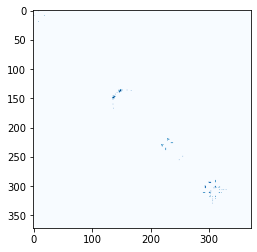

In [28]:
plt.imshow(contact_esm,cmap='Blues')

In [34]:
pwd

'/Users/rohan/Desktop/DTI_setup'

In [10]:
esm1b,esm1b_batch_converter=load_ESM_1b()


[326,
 292,
 737,
 393,
 954,
 706,
 509,
 592,
 676,
 659,
 890,
 620,
 820,
 999,
 559,
 545,
 524,
 491,
 762,
 666,
 558,
 499,
 763,
 451,
 671,
 370,
 716,
 1009,
 651,
 307,
 436,
 912,
 735,
 364,
 839,
 942,
 984,
 360,
 473,
 847,
 822,
 382,
 788,
 1001,
 326,
 385,
 473,
 616,
 778,
 344,
 322,
 752,
 358,
 588,
 655,
 465,
 502,
 367,
 878,
 926,
 488,
 646,
 481,
 465,
 427,
 313,
 422,
 520,
 460,
 800,
 311,
 416,
 527,
 816,
 482,
 414,
 489,
 569,
 729,
 478,
 479,
 629,
 270,
 846,
 447]

In [51]:
for i,j in enumerate(prot_len):
    print(i,j)
    fasta=randSeq(["A","C","D", "E","F","G","H","I","K","L", "M","N","P","Q","R","S", "T","V","W","Y"],j)
    contact_esm=getContactMap_fromESM(esm1b,esm1b_batch_converter,fasta)
    print(contact_esm.shape)
    filename='/Users/rohan/Desktop/DTI_setup/random_kiba1/'+list2[i][:len(list2[i]) - 2]
    np.save(filename,contact_esm)

0 431
(431, 431)
1 574
(574, 574)
2 725
(725, 725)
3 970
(970, 970)
4 476
(476, 476)
5 756
(756, 756)
6 403
(403, 403)
7 740
(740, 740)
8 745
(745, 745)
9 365
(365, 365)
10 556
(556, 556)
11 454
(454, 454)
12 272
(272, 272)
13 588
(588, 588)
14 661
(661, 661)
15 802
(802, 802)
16 772
(772, 772)
17 890
(890, 890)
18 591
(591, 591)
19 543
(543, 543)
20 648
(648, 648)
21 796
(796, 796)
22 697
(697, 697)
23 671
(671, 671)
24 509
(509, 509)
25 537
(537, 537)
26 297
(297, 297)
27 822
(822, 822)
28 972
(972, 972)
29 543
(543, 543)
30 512
(512, 512)
31 526
(526, 526)
32 529
(529, 529)
33 976
(976, 976)
34 404
(404, 404)
35 822
(822, 822)
36 303
(303, 303)
37 536
(536, 536)
38 766
(766, 766)
39 406
(406, 406)
40 822
(822, 822)
41 672
(672, 672)
42 351
(351, 351)
43 350
(350, 350)
44 821
(821, 821)
45 802
(802, 802)
46 806
(806, 806)
47 351
(351, 351)
48 351
(351, 351)
49 525
(525, 525)
50 683
(683, 683)
51 298
(298, 298)
52 379
(379, 379)
53 753
(753, 753)
54 360
(360, 360)
55 976
(976, 976)
56

KeyboardInterrupt: 

In [37]:
len(list1)

188

In [38]:
len(list2)

188

In [42]:

for i,j in enumerate(prot_len[103:len(prot_len)]):
    print(i,j)
    fasta=randSeq(["A","C","D", "E","F","G","H","I","K","L", "M","N","P","Q","R","S", "T","V","W","Y"],j)
    contact_esm=getContactMap_fromESM(esm1b,esm1b_batch_converter,fasta)
    print(contact_esm.shape)
    filename='/Users/rohan/Desktop/DTI_setup/random_kiba/'+list2[i][:len(list2[i]) - 2]
    np.save(filename,contact_esm)

0 326
(326, 326)
1 292
(292, 292)
2 737


KeyboardInterrupt: 

In [49]:
len(prot_len)

187

In [54]:
for i,j in enumerate(prot_len):
    print(i,j)
    fasta=randSeq(["A","C","D", "E","F","G","H","I","K","L", "M","N","P","Q","R","S", "T","V","W","Y"],j)
    contact_esm=getContactMap_fromESM(esm1b,esm1b_batch_converter,fasta)
    print(contact_esm.shape)
    filename='/Users/rohan/Desktop/DTI_setup/random_kiba1/'+list2[i][:len(list2[i]) - 1]
    np.save(filename,contact_esm)
    print(filename)

0 431
(431, 431)
/Users/rohan/Desktop/DTI_setup/random_kiba1/O00141
1 574
(574, 574)
/Users/rohan/Desktop/DTI_setup/random_kiba1/O00311
2 725
(725, 725)
/Users/rohan/Desktop/DTI_setup/random_kiba1/O00418
3 970
(970, 970)
/Users/rohan/Desktop/DTI_setup/random_kiba1/O00444
4 476
(476, 476)
/Users/rohan/Desktop/DTI_setup/random_kiba1/O14757
5 756
(756, 756)
/Users/rohan/Desktop/DTI_setup/random_kiba1/O14920
6 403
(403, 403)
/Users/rohan/Desktop/DTI_setup/random_kiba1/O14965
7 740
(740, 740)
/Users/rohan/Desktop/DTI_setup/random_kiba1/O15075
8 745
(745, 745)
/Users/rohan/Desktop/DTI_setup/random_kiba1/O15111
9 365
(365, 365)
/Users/rohan/Desktop/DTI_setup/random_kiba1/O15264
10 556
(556, 556)
/Users/rohan/Desktop/DTI_setup/random_kiba1/O15530
11 454
(454, 454)
/Users/rohan/Desktop/DTI_setup/random_kiba1/O43293
12 272
(272, 272)
/Users/rohan/Desktop/DTI_setup/random_kiba1/O43741
13 588
(588, 588)
/Users/rohan/Desktop/DTI_setup/random_kiba1/O43781
14 661
(661, 661)
/Users/rohan/Desktop/DTI_s

(491, 491)
/Users/rohan/Desktop/DTI_setup/random_kiba1/Q13188
120 762
(762, 762)
/Users/rohan/Desktop/DTI_setup/random_kiba1/Q13237
121 666
(666, 666)
/Users/rohan/Desktop/DTI_setup/random_kiba1/Q13554
122 558
(558, 558)
/Users/rohan/Desktop/DTI_setup/random_kiba1/Q13555
123 499
(499, 499)
/Users/rohan/Desktop/DTI_setup/random_kiba1/Q13557
124 763
(763, 763)
/Users/rohan/Desktop/DTI_setup/random_kiba1/Q13627
125 451
(451, 451)
/Users/rohan/Desktop/DTI_setup/random_kiba1/Q13882
126 671
(671, 671)
/Users/rohan/Desktop/DTI_setup/random_kiba1/Q13976
127 370
(370, 370)
/Users/rohan/Desktop/DTI_setup/random_kiba1/Q14012
128 716
(716, 716)
/Users/rohan/Desktop/DTI_setup/random_kiba1/Q14164
129 1009
(1009, 1009)
/Users/rohan/Desktop/DTI_setup/random_kiba1/Q14289
130 651
(651, 651)
/Users/rohan/Desktop/DTI_setup/random_kiba1/Q14680
131 307
(307, 307)
/Users/rohan/Desktop/DTI_setup/random_kiba1/Q15078
132 436
(436, 436)
/Users/rohan/Desktop/DTI_setup/random_kiba1/Q15118
133 912
(912, 912)
/Users

In [8]:
list2[1][:len(list2[1]) - 1]

'O00311'

In [11]:
list2

['O00141\n',
 'O00311\n',
 'O00418\n',
 'O00444\n',
 'O14757\n',
 'O14920\n',
 'O14965\n',
 'O15075\n',
 'O15111\n',
 'O15264\n',
 'O15530\n',
 'O43293\n',
 'O43741\n',
 'O43781\n',
 'O60285\n',
 'O75582\n',
 'O75676\n',
 'O94806\n',
 'O96013\n',
 'O96017\n',
 'P04049\n',
 'P04629\n',
 'P05129\n',
 'P05771\n',
 'P06239\n',
 'P06241\n',
 'P06493\n',
 'P07332\n',
 'P07333\n',
 'P07947\n',
 'P07948\n',
 'P08631\n',
 'P09769\n',
 'P10721\n',
 'P11309\n',
 'P11362\n',
 'P11802\n',
 'P12931\n',
 'P15056\n',
 'P15735\n',
 'P16591\n',
 'P17252\n',
 'P17612\n',
 'P19784\n',
 'P21802\n',
 'P22455\n',
 'P22607\n',
 'P22612\n',
 'P22694\n',
 'P23443\n',
 'P24723\n',
 'P24941\n',
 'P27361\n',
 'P27448\n',
 'P28482\n',
 'P29317\n',
 'P29376\n',
 'P30291\n',
 'P30530\n',
 'P31749\n',
 'P31751\n',
 'P34947\n',
 'P36507\n',
 'P36888\n',
 'P41240\n',
 'P41279\n',
 'P41743\n',
 'P42679\n',
 'P42685\n',
 'P43403\n',
 'P43405\n',
 'P45983\n',
 'P45984\n',
 'P48729\n',
 'P48730\n',
 'P49137\n',
 'P49336\n',

In [12]:
import requests
import time

uniprot_ids = ['P26378', 'O35433', 'Q02910']

url = 'https://www.uniprot.org/uniprot/'

protein_to_pdb = {}
for protein in uniprot_ids:
    params = {
        'format': 'tab',
        'query': 'ID:{}'.format(protein),
        'columns': 'id,database(PDB)'
    }
    contact = ""  # Please set your email address here.
    headers = {'User-Agent': 'Python {}'.format(contact)}
    r = requests.get(url, params=params, headers=headers)

    protein_to_pdb[protein] = str(r.text).splitlines()[-1].split('\t')[-1].split(';')
    protein_to_pdb[protein].pop(-1)
    time.sleep(1)  # be respectful and don't overwhelm the server with requests

print(protein_to_pdb)

{'P26378': ['1FXL', '1G2E'], 'O35433': ['2NYJ', '2PNN', '3J5P', '3J5Q', '3J5R', '3J9J', '3SUI', '5IRX', '5IRZ', '5IS0', '7L2H', '7L2I', '7L2J', '7L2K', '7L2L', '7L2M', '7L2N', '7L2O', '7L2P', '7L2R', '7L2S', '7L2T', '7L2U', '7L2V', '7L2W', '7L2X', '7LP9', '7LPA', '7LPB', '7LPC', '7LPD', '7LPE', '7MZ5', '7MZ6', '7MZ7', '7MZ9', '7MZA', '7MZB', '7MZC', '7MZD', '7MZE'], 'Q02910': []}


In [13]:
import requests
import time

uniprot_ids = list2

url = 'https://www.uniprot.org/uniprot/'

protein_to_pdb = {}
for protein in uniprot_ids:
    params = {
        'format': 'tab',
        'query': 'ID:{}'.format(protein),
        'columns': 'id,database(PDB)'
    }
    contact = ""  # Please set your email address here.
    headers = {'User-Agent': 'Python {}'.format(contact)}
    r = requests.get(url, params=params, headers=headers)

    protein_to_pdb[protein] = str(r.text).splitlines()[-1].split('\t')[-1].split(';')
    protein_to_pdb[protein].pop(-1)
    time.sleep(1)  # be respectful and don't overwhelm the server with requests

print(protein_to_pdb)

{'O00141\n': ['2R5T', '3HDM', '3HDN'], 'O00311\n': ['4F99', '4F9A', '4F9B', '4F9C', '5UWQ', '5UWR', '6YA6', '6YA7', '6YA8'], 'O00418\n': ['5J8H', '5KS5', '6NX4'], 'O00444\n': ['2N19', '3COK', '4JXF', '4N7V', '4N7Z', '4N9J', '4YUR', '4YYP', '5LHY', '5LHZ', '6N45', '6N46', '6W38', '6W3I', '6W3J'], 'O14757\n': ['1IA8', '1NVQ', '1NVR', '1NVS', '1ZLT', '1ZYS', '2AYP', '2BR1', '2BRB', '2BRG', '2BRH', '2BRM', '2BRN', '2BRO', '2C3J', '2C3K', '2C3L', '2CGU', '2CGV', '2CGW', '2CGX', '2E9N', '2E9O', '2E9P', '2E9U', '2E9V', '2GDO', '2GHG', '2HOG', '2HXL', '2HXQ', '2HY0', '2QHM', '2QHN', '2R0U', '2WMQ', '2WMR', '2WMS', '2WMT', '2WMU', '2WMV', '2WMW', '2WMX', '2X8D', '2X8E', '2X8I', '2XEY', '2XEZ', '2XF0', '2YDI', '2YDJ', '2YDK', '2YER', '2YEX', '2YM3', '2YM4', '2YM5', '2YM6', '2YM7', '2YM8', '2YWP', '3F9N', '3JVR', '3JVS', '3NLB', '3OT3', '3OT8', '3PA3', '3PA4', '3PA5', '3TKH', '3TKI', '3U9N', '4FSM', '4FSN', '4FSQ', '4FSR', '4FST', '4FSU', '4FSW', '4FSY', '4FSZ', '4FT0', '4FT3', '4FT5', '4FT7', '4

In [14]:
protein_to_pdb.keys()

dict_keys(['O00141\n', 'O00311\n', 'O00418\n', 'O00444\n', 'O14757\n', 'O14920\n', 'O14965\n', 'O15075\n', 'O15111\n', 'O15264\n', 'O15530\n', 'O43293\n', 'O43741\n', 'O43781\n', 'O60285\n', 'O75582\n', 'O75676\n', 'O94806\n', 'O96013\n', 'O96017\n', 'P04049\n', 'P04629\n', 'P05129\n', 'P05771\n', 'P06239\n', 'P06241\n', 'P06493\n', 'P07332\n', 'P07333\n', 'P07947\n', 'P07948\n', 'P08631\n', 'P09769\n', 'P10721\n', 'P11309\n', 'P11362\n', 'P11802\n', 'P12931\n', 'P15056\n', 'P15735\n', 'P16591\n', 'P17252\n', 'P17612\n', 'P19784\n', 'P21802\n', 'P22455\n', 'P22607\n', 'P22612\n', 'P22694\n', 'P23443\n', 'P24723\n', 'P24941\n', 'P27361\n', 'P27448\n', 'P28482\n', 'P29317\n', 'P29376\n', 'P30291\n', 'P30530\n', 'P31749\n', 'P31751\n', 'P34947\n', 'P36507\n', 'P36888\n', 'P41240\n', 'P41279\n', 'P41743\n', 'P42679\n', 'P42685\n', 'P43403\n', 'P43405\n', 'P45983\n', 'P45984\n', 'P48729\n', 'P48730\n', 'P49137\n', 'P49336\n', 'P49674\n', 'P49759\n', 'P49760\n', 'P49840\n', 'P49841\n', 'P506

In [19]:
with open("KIBA_UniprotID_PDB1.txt", 'w') as f: 
    for key, value in protein_to_pdb.items(): 
        f.write('%s:%s\n' % (key[:len(key)-1], value))

In [18]:
i=0
j=0
for key, value in protein_to_pdb.items(): 
    print(key[:len(key)-1],value)
    if len(value)==0:
        j=j+1
    i=i+1
print(i,j)

O00141 ['2R5T', '3HDM', '3HDN']
O00311 ['4F99', '4F9A', '4F9B', '4F9C', '5UWQ', '5UWR', '6YA6', '6YA7', '6YA8']
O00418 ['5J8H', '5KS5', '6NX4']
O00444 ['2N19', '3COK', '4JXF', '4N7V', '4N7Z', '4N9J', '4YUR', '4YYP', '5LHY', '5LHZ', '6N45', '6N46', '6W38', '6W3I', '6W3J']
O14757 ['1IA8', '1NVQ', '1NVR', '1NVS', '1ZLT', '1ZYS', '2AYP', '2BR1', '2BRB', '2BRG', '2BRH', '2BRM', '2BRN', '2BRO', '2C3J', '2C3K', '2C3L', '2CGU', '2CGV', '2CGW', '2CGX', '2E9N', '2E9O', '2E9P', '2E9U', '2E9V', '2GDO', '2GHG', '2HOG', '2HXL', '2HXQ', '2HY0', '2QHM', '2QHN', '2R0U', '2WMQ', '2WMR', '2WMS', '2WMT', '2WMU', '2WMV', '2WMW', '2WMX', '2X8D', '2X8E', '2X8I', '2XEY', '2XEZ', '2XF0', '2YDI', '2YDJ', '2YDK', '2YER', '2YEX', '2YM3', '2YM4', '2YM5', '2YM6', '2YM7', '2YM8', '2YWP', '3F9N', '3JVR', '3JVS', '3NLB', '3OT3', '3OT8', '3PA3', '3PA4', '3PA5', '3TKH', '3TKI', '3U9N', '4FSM', '4FSN', '4FSQ', '4FSR', '4FST', '4FSU', '4FSW', '4FSY', '4FSZ', '4FT0', '4FT3', '4FT5', '4FT7', '4FT9', '4FTA', '4FTC', '4FTI', 

In [17]:
187-34

153

In [20]:
import os
import pandas as pd
import Bio.PDB.PDBList as biopy
import PCN
import traceback
import tarfile
import random
import numpy as np
import networkx as nx
import MDAnalysis as mda
import random
import Bio
import matplotlib.pyplot as plt

In [ ]:
pdblist = biopy()
PDB_IDs = pdb_list3
counter = 1
for PDB_ID in PDB_IDs:
    PDB_IDs_lower = str(PDB_ID).lower()
    if os.path.isfile(f'//Users/rohan/Desktop/contact_map_analysis/data_main/pdb_all/pdb{PDB_IDs_lower}.ent'):
        print("File already exists")
        continue
    else:
        print(f'At entry {counter} out of {len(PDB_IDs)} entries.')
        pdblist.retrieve_pdb_file(pdb_code = PDB_ID, file_format = 'pdb', pdir = '/Users/rohan/Desktop/contact_map_analysis/data_main/pdb_all/')
        counter += 1

In [23]:
for key, value in protein_to_pdb.items():
#     esm_path='/Users/rohan/Desktop/contact_map_analysis/cmaps/esm_cmaps/'+key[:len(key)-1]+'.npy'
#     esm_cmap=np.load(esm_path)
#     esm_shape=np.shape(esm_cmap)[0]
    pdblist = biopy()
    
    for i in value:
        if len(value)!=0:
            save_dir='/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/'+key[:len(key)-1]
            print(save_dir)
            isExist = os.path.exists(save_dir)
            print(isExist)
            if not isExist:
                os.makedirs(save_dir)
            pdb_id=str(i).lower()
            print(pdb_id)
            pdblist.retrieve_pdb_file(pdb_code = pdb_id, file_format = 'pdb', pdir = save_dir)
        else:
            continue


/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O00141
False
2r5t
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O00141
True
3hdm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O00141
True
3hdn
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O00311
False
4f99
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O00311
True
4f9a
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O00311
True
4f9b
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O00311
True
4f9c
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O00311
True
5uwq
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O00311
True
5uwr
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O00311
True
6ya6
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O00311
True
6ya7
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O00311
True
6ya8
/Users/rohan/Desktop/contact_map_analysis/cmaps/ki

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
2wmx
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
2x8d
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
2x8e
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
2x8i
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
2xey
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
2xez
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
2xf0
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
2ydi
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
2ydj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
2ydk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
2yer
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
2yex
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
5oor
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
5oot
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
5op2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
5op4
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
5op5
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
5op7
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
5opb
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
5opr
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
5ops
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
5opu
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
5opv
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14757
True
5oq5
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
3ha6
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
3k5u
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
3lau
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
3m11
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
3myg
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
3nrm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
3o50
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
3o51
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
3p9j
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
3qbn
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
3r21
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
3r22
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
5dt4
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
5ew9
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
5g15
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
5g1x
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
5l8j
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
5l8k
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
5l8l
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
5lxm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
5obj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
5obr
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
5odt
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O14965
True
5one
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15111
False
3brt
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15111
True
5ebz
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15111
True
5tqw
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15111
True
5tqx
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15111
True
5tqy
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15264
False
3coi
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15264
True
4eyj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15264
True
4eym
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15264
True
4myg
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15264
True
4yno
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15264
True
5ekn
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15264
True
5eko
/Users/rohan/Desktop/contact_map_analysis/cmaps/ki

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15530
True
5ho7
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15530
True
5ho8
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15530
True
5lvl
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15530
True
5lvm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15530
True
5lvn
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15530
True
5lvo
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15530
True
5lvp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15530
True
5mrd
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O15530
True
6wjq
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O43293
False
1yrp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O43293
True
2j90
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O43293
True
3bhy
/Users/rohan/Desktop/contact_map_analysis/cmaps/kib

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O96013
True
6wlx
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O96013
True
6wly
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O96013
True
7cmb
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O96013
True
7cp3
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O96013
True
7cp4
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O96017
False
1gxc
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O96017
True
2cn5
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O96017
True
2cn8
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O96017
True
2w0j
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O96017
True
2w7x
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O96017
True
2wtc
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/O96017
True
2wtd
/Users/rohan/Desktop/contact_map_analysis/cmaps/kib

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P04049
True
7jhp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P04629
False
1he7
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P04629
True
1shc
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P04629
True
1wwa
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P04629
True
1www
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P04629
True
2ifg
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P04629
True
2n90
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P04629
True
4aoj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P04629
True
4crp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P04629
True
4f0i
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P04629
True
4gt5
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P04629
True
4pmm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kib

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06239
True
1qpe
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06239
True
1qpj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06239
True
1x27
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06239
True
2iim
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06239
True
2of2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06239
True
2of4
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06239
True
2ofu
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06239
True
2ofv
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06239
True
2og8
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06239
True
2pl0
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06239
True
2zm1
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06239
True
2zm4
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06241
True
7a2k
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06241
True
7a2l
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06241
True
7a2m
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06241
True
7a2n
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06241
True
7a2o
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06241
True
7a2p
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06241
True
7a2q
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06241
True
7a2r
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06241
True
7a2s
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06241
True
7a2t
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06241
True
7a2u
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P06241
True
7a2v
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P08631
True
2oj2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P08631
True
3hck
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P08631
True
3nhn
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P08631
True
3rbb
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P08631
True
3rea
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P08631
True
3reb
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P08631
True
3vry
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P08631
True
3vrz
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P08631
True
3vs0
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P08631
True
3vs1
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P08631
True
3vs2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P08631
True
3vs3
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
2bzk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
2c3i
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
2j2i
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
2o3p
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
2o63
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
2o64
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
2o65
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
2obj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
2oi4
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
2xix
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
2xiy
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
2xiz
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
4n6y
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
4n6z
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
4n70
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
4rbl
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
4rc2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
4rc3
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
4rc4
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
4rpv
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
4ty1
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
4wrs
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
4wsy
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
4wt6
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
6pdo
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
6pdp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
6qxk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
6vru
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
6vrv
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
6ykd
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
7oov
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
7oow
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11309
True
7oox
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11362
False
1agw
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11362
True
1cvs
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11362
True
1evt
/Users/rohan/Desktop/contact_map_analysis/cmaps/kib

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11362
True
6nvl
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11362
True
6p68
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11362
True
6p69
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11802
False
2w96
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11802
True
2w99
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11802
True
2w9f
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11802
True
2w9z
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11802
True
3g33
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11802
True
5fwk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11802
True
5fwl
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11802
True
5fwm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P11802
True
5fwp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kib

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P12931
True
4mxo
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P12931
True
4mxx
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P12931
True
4mxy
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P12931
True
4mxz
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P12931
True
6ate
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P12931
True
6c4s
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P12931
True
6e6e
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P12931
True
6ehj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P12931
True
7ng7
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P15056
False
1uwh
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P15056
True
1uwj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P15056
True
2fb8
/Users/rohan/Desktop/contact_map_analysis/cmaps/kib

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P15056
True
5val
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P15056
True
5vam
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P15056
True
5vr3
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P15056
True
5vyk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P15056
True
6b8u
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P15056
True
6cad
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P15056
True
6n0p
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P15056
True
6n0q
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P15056
True
6nsq
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P15056
True
6nyb
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P15056
True
6p3d
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P15056
True
6p7g
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P17612
True
5uzk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P17612
True
6byr
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P17612
True
6bys
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P17612
True
6c0u
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P17612
True
6frx
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P17612
True
6no7
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P17612
True
6qj7
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P17612
True
6wjf
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P17612
True
6wjg
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P19784
False
3e3b
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P19784
True
3ofm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P19784
True
3u87
/Users/rohan/Desktop/contact_map_analysis/cmaps/kib

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P21802
True
5uhn
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P21802
True
5ui0
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P21802
True
6agx
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P21802
True
6lvk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P21802
True
6lvl
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P21802
True
6v6q
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P21802
True
7kia
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P21802
True
7kie
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P22455
False
4qq5
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P22455
True
4qqc
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P22455
True
4qqj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P22455
True
4qqt
/Users/rohan/Desktop/contact_map_analysis/cmaps/kib

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1dm2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1e1v
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1e1x
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1e9h
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1f5q
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1fin
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1fq1
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1fvt
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1fvv
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1g5s
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1gih
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1gii
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1vyz
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1w0x
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1w8c
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1w98
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1wcc
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1y8y
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1y91
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
1ykr
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
2a0c
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
2a4l
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
2b52
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
2b53
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
2vta
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
2vth
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
2vti
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
2vtj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
2vtl
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
2vtm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
2vtn
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
2vto
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
2vtp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
2vtq
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
2vtr
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
2vts
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
3qtr
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
3qts
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
3qtu
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
3qtw
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
3qtx
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
3qtz
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
3qu0
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
3qwj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
3qwk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
3qx2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
3qx4
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
3qxo
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
3unk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
3wbl
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
4acm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
4bck
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
4bcm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
4bcn
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
4bco
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
4bcp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
4bcq
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
4bgh
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
4bzd
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
4cfm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
5iex
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
5iey
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
5if1
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
5jq5
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
5jq8
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
5k4j
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
5l2w
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
5lmk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
5mhq
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
5nev
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
5oo0
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P24941
True
5oo1
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
3d42
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
3d44
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
3i5z
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
3i60
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
3sa0
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
3tei
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
3w55
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
4fmq
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
4fux
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
4fuy
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
4fv0
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
4fv1
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
6g91
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
6g92
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
6g93
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
6g97
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
6g9a
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
6g9d
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
6g9h
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
6g9j
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
6g9k
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
6g9m
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
6g9n
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P28482
True
6gdm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P29317
True
5nk0
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P29317
True
5nk1
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P29317
True
5nk2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P29317
True
5nk3
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P29317
True
5nk4
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P29317
True
5nk5
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P29317
True
5nk6
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P29317
True
5nk7
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P29317
True
5nk8
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P29317
True
5nk9
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P29317
True
5nka
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P29317
True
5nkb
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P30291
True
5vda
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P30291
True
7n3u
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P30530
False
2c5d
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P30530
True
4ra0
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P30530
True
5u6b
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P30530
True
5vxz
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P31749
False
1h10
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P31749
True
1unp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P31749
True
1unq
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P31749
True
1unr
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P31749
True
2uvm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P31749
True
2uzr
/Users/rohan/Desktop/contact_map_analysis/cmaps/ki

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P41240
True
1csk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P41240
True
3d7t
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P41240
True
3d7u
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P41240
True
3eac
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P41240
True
3eaz
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P41279
False
4y83
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P41279
True
4y85
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P41279
True
5iu2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P41743
False
1vd2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P41743
True
1wmh
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P41743
True
1zrz
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P41743
True
3a8w
/Users/rohan/Desktop/contact_map_analysis/cmaps/ki

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P43405
True
4rx9
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P43405
True
4wnm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P43405
True
4xg2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P43405
True
4xg3
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P43405
True
4xg4
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P43405
True
4xg6
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P43405
True
4xg7
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P43405
True
4xg8
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P43405
True
4xg9
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P43405
True
4yjo
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P43405
True
4yjp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P43405
True
4yjq
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P45983
True
4ux9
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P45983
True
4yr8
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P45983
True
5lw1
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P45983
True
6f5e
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P45983
True
6zr5
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P45984
False
3e7o
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P45984
True
3npc
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P45984
True
7cml
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P48729
False
5fqd
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P48729
True
6gzd
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P48730
False
3uys
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P48730
True
3uyt
/Users/rohan/Desktop/contact_map_analysis/cmaps/k

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49336
True
4f6w
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49336
True
4f70
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49336
True
4f7j
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49336
True
4f7l
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49336
True
4f7n
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49336
True
4f7s
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49336
True
4g6l
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49336
True
5bnj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49336
True
5cei
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49336
True
5fgk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49336
True
5hbe
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49336
True
5hbh
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
1j1c
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
1o6k
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
1o6l
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
1o9u
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
1pyx
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
1q3d
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
1q3w
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
1q41
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
1q4l
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
1q5k
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
1r0e
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
1uv5
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
6buu
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
6gjo
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
6gn1
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
6h0u
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
6hk3
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
6hk4
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
6hk7
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
6npz
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
6tcu
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
6v6l
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
6y9r
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P49841
True
6y9s
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P51955
True
2w5h
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P51955
True
2wqo
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P51955
True
2xk3
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P51955
True
2xk4
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P51955
True
2xk6
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P51955
True
2xk7
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P51955
True
2xk8
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P51955
True
2xkc
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P51955
True
2xkd
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P51955
True
2xke
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P51955
True
2xkf
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P51955
True
2xnm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53350
True
4lkm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53350
True
4o56
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53350
True
4o6w
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53350
True
4o9w
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53350
True
4rcp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53350
True
4whh
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53350
True
4whk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53350
True
4whl
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53350
True
4x9r
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53350
True
4x9v
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53350
True
4x9w
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53350
True
5j19
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53779
True
4u79
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53779
True
4w4v
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53779
True
4w4w
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53779
True
4w4x
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53779
True
4w4y
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53779
True
4whz
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53779
True
4x21
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53779
True
4y46
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53779
True
4y5h
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53779
True
4z9l
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53779
True
6ekd
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P53779
True
6emh
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P54760
True
6fnm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P67870
False
1ds5
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P67870
True
1jwh
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P67870
True
1qf8
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P67870
True
3eed
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P67870
True
4dgl
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P67870
True
4md7
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P67870
True
4md8
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P67870
True
4md9
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P67870
True
4nh1
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P67870
True
6q38
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
False
1jwh
/Users/rohan/Desktop/contact_map_analysis/cmaps/ki

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5cqw
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5cs6
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5csh
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5csp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5csv
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5ct0
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5ctp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5cu0
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5cu2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5cu3
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5cu4
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5cu6
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5oul
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5oum
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5ouu
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5owh
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5owl
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5oyf
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5t1h
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5vie
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5vif
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5zn0
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5zn1
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
5zn2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
7a4b
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
7a4c
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
7at5
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
7b8h
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
7b8i
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
7bu4
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P68400
True
7l1x
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/P78368
False
2c47
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q00534
False
1bi7
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q00534
True
1bi8
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q00534
True
1blx
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q00534
True
1g3n
/Users/rohan/Desktop/contact_map_analysis/cmaps/ki

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q02750
True
5eym
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q02750
True
5hze
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q02750
True
5yt3
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q02750
True
6nyb
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q02750
True
6pp9
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q02750
True
6q0j
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q02750
True
6q0t
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q02750
True
6u2g
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q02750
True
6v2w
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q02750
True
6x2p
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q02750
True
6x2s
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q02750
True
6x2x
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q04771
True
5s80
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q04771
True
5s81
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q04771
True
5s82
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q04771
True
5s83
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q04771
True
5s84
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q04771
True
5s85
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q04771
True
5s86
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q04771
True
5s87
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q04771
True
5s88
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q04771
True
5s89
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q04771
True
5s8a
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q04771
True
5s8b
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q06187
True
5fbo
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q06187
True
5j87
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q06187
True
5jrs
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q06187
True
5kup
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q06187
True
5p9f
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q06187
True
5p9g
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q06187
True
5p9h
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q06187
True
5p9i
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q06187
True
5p9j
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q06187
True
5p9k
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q06187
True
5p9l
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q06187
True
5p9m
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q06418
False
1rhf
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q08881
False
1sm2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q08881
True
1snu
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q08881
True
1snx
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q08881
True
2e6i
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q08881
True
2lmj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q08881
True
2yuq
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q08881
True
3miy
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q08881
True
3mj1
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q08881
True
3mj2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q08881
True
3qgw
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q08881
True
3qgy
/Users/rohan/Desktop/contact_map_analysis/cmaps/ki

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13131
False
4red
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13131
True
4rer
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13131
True
4rew
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13131
True
5ezv
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13131
True
6c9f
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13131
True
6c9g
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13131
True
6c9h
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13131
True
6c9j
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13131
True
7jhg
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13131
True
7jhh
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13131
True
7jij
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13153
False
1f3m
/Users/rohan/Desktop/contact_map_analysis/cmaps/ki

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13627
True
4mq1
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13627
True
4mq2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13627
True
4nct
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13627
True
4ylj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13627
True
4ylk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13627
True
4yll
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13627
True
4yu2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13627
True
5a3x
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13627
True
5a4e
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13627
True
5a4l
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13627
True
5a4q
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13627
True
5a4t
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13882
True
6cz2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13882
True
6cz3
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13882
True
6cz4
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13976
False
1zxa
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13976
True
3nmd
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13976
True
3ocp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13976
True
3od0
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13976
True
3ogj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13976
True
4ku7
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13976
True
4ku8
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13976
True
4qx5
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q13976
True
4qxk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kib

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q14680
True
5tvt
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q14680
True
5twl
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q14680
True
5twu
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q14680
True
5twy
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q14680
True
5twz
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q14680
True
5tx3
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q14680
True
6gvx
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q14680
True
6vxr
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q15078
False
1h4l
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q15078
True
1ung
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q15078
True
1unh
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q15078
True
1unl
/Users/rohan/Desktop/contact_map_analysis/cmaps/kib

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
1w82
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
1w83
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
1w84
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
1wbn
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
1wbo
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
1wbs
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
1wbt
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
1wbv
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
1wbw
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
1wfc
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
1yqj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
1zyj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3gcs
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3gcu
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3gcv
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3gfe
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3gi3
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3ha8
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3hec
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3heg
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3hl7
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3hll
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3hp2
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3hp5
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3s3i
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3s4q
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3u8w
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3uvp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3uvq
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3uvr
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3zs5
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3zsg
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3zsh
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3zsi
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
3zya
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
4a9y
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
6ohd
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
6qdz
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
6qe1
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
6qyx
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
6rfo
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
6sfi
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
6sfj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
6sfk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
6sfo
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
6tca
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
6zqs
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q16539
True
6zwp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q96SB4
True
5xv7
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q96SB4
True
6fad
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q96SB4
True
7dd1
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9BUB5
False
2hw6
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9BUB5
True
2y9q
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9BUB5
True
5wvd
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9BZL6
False
2coa
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9BZL6
True
3bgm
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9BZL6
True
4nnx
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9BZL6
True
4nny
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9H4B4
False
4b6l
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9HAZ1
False
6fyv
/Users/rohan/Desktop/contact_map_analysis/cmaps/

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9NWZ3
True
6o95
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9NWZ3
True
6o9d
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9NWZ3
True
6rfi
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9NWZ3
True
6rfj
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9NWZ3
True
6thw
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9NWZ3
True
6thx
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9NWZ3
True
6thz
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9NWZ3
True
6ti8
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9NWZ3
True
6tia
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9NWZ3
True
6uya
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9NWZ3
True
6vql
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9NWZ3
True
7c2v
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9UQM7
True
6of8
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9UQM7
True
6vzk
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9UQM7
True
6w4o
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9UQM7
True
6w4p
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9UQM7
True
6x5g
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9UQM7
True
6x5q
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9UQM7
True
6x8v
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9UQM7
True
6xbp
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9UQM7
True
6xbx
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9UQM7
True
6xdl
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9UQM7
True
6xdu
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/Q9UQM7
True
6xf0
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba

In [ ]:
esm_path='/Users/rohan/Desktop/contact_map_analysis/cmaps/esm_cmaps/'+key[:len(key)-1]+'.npy'
esm_cmamp=np.load(esm_path)

In [33]:
import os
import pandas as pd
import Bio.PDB.PDBList as biopy
import PCN
import traceback
import tarfile
import random
import numpy as np
import networkx as nx
import MDAnalysis as mda
import random
import Bio
import matplotlib.pyplot as plt
import esm
import torch
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string
import MDAnalysis as mda
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,matthews_corrcoef,roc_curve, auc
torch.set_grad_enabled(False)


In [4]:
def getContactMap_fromPDB(PDB_file):
    """ Takes a PDB file and creates a PCN from the alpha carbons and computes distance matrix 
    followed by generating a contact map with 8.0 Å threshold value."""
    protein_contact_network = PCN.PCN(PDB_file)
    C_alphas = protein_contact_network.get_C_alphas()
    chain_length = protein_contact_network.get_chain_length(C_alphas)
    if protein_contact_network.get_link_lengths(C_alphas) is not None:
        distance_matrix=protein_contact_network.get_link_lengths(C_alphas)
        print(distance_matrix)
        contact_map = distance_matrix > 0
        contact_map=np.multiply(contact_map,1)
        return contact_map
    else:
        return None

In [45]:
for key, value in protein_to_pdb.items():
    esm_path='/Users/rohan/Desktop/contact_map_analysis/cmaps/esm_cmaps/'+key[:len(key)-1]+'.npy'
    esm_cmap=np.load(esm_path)
    esm_shape=np.shape(esm_cmap)[0]
    
    for i in value:
        if len(value)!=0:
            save_dir='/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/'+key[:len(key)-1]+"/"
            save_dir1='/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_cmaps/'
            print(save_dir)
            isExist = os.path.exists(save_dir)
            print(isExist)
            if not isExist:
                os.makedirs(save_dir)
            pdb_id=str(i).lower()
            PDB_file='/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/'+key[:len(key)-1]+'/pdb'+pdb_id+'.ent'
            #PDB_file = f'//Users/rohan/Desktop/contact_map_analysis/data_main/pdb_files/pdb{pdb_id}.ent'
            pdb_cmap=getContactMap_fromPDB(PDB_file)
            pdb_path=save_dir+pdb_id+'.npy'
            np.save(pdb_path,pdb_cmap)
            pdb_shape=np.shape(pdb_cmap)[0]
            print("pdb_esm")
            print(pdb_shape,esm_shape)
            if pdb_shape==esm_shape:
                cmap_save=save_dir1+key[:len(key)-1]+'.npy'
                np.save(cmap_save,pdb_cmap)
                continue
        else:
            continue


/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O00141/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
284 431
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O00141/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
285 431
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O00141/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
280 431
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O00311/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
264 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14757/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
272 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14757/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
271 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14757/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
268 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
255 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14757/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
243 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14757/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
249 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14757/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
247 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
257 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14757/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
269 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14757/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
272 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14757/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
257 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
275 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14757/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
256 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14757/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
271 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14757/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
264 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
265 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14757/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
261 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14757/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
263 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14757/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
262 476
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
253 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14965/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
254 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14965/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
241 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14965/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
266 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O

[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
264 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14965/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
266 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14965/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
264 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14965/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
263 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O

[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
259 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14965/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
259 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14965/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
251 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14965/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
249 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
255 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14965/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
259 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14965/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
258 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14965/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
265 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
257 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14965/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
255 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14965/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
265 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O14965/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
260 403
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
655 745
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O15111/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
32 745
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O15111/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
54 745
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O15111/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
54 745
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O152

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
288 556
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O15530/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
274 556
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O15530/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
276 556
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O15530/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
278 556
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
302 556
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O15530/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
303 556
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O15530/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
315 556
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O15530/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
273 556
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
301 591
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O96013/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
296 591
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O96013/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
293 591
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O96013/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
300 591
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
283 543
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O96017/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
266 543
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O96017/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
275 543
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O96017/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
287 543
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
282 543
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O96017/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
290 543
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O96017/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
282 543
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/O96017/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
286 543
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
166 648
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P04629/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
114 796
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P04629/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
195 796
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P04629/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
105 796
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
291 796
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P04629/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
296 796
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P04629/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
299 796
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P04629/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
272 796
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
38 509
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P06239/
True
[[0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 2. 3. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 3. 2. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
300 509
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P06239/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
272 509
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P06239/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
271 509
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P06239/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
255 509
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[ 0.  0.  2. ...  0.  0.  0.]
 [ 0.  0.  0. ... 96.  0.  0.]
 [ 2.  0.  0. ...  0.  0.  0.]
 ...
 [ 0. 96.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
pdb_esm
100 537
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P06241/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
100 537
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P06241/
True
[[ 0.  0.  2. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 2.  0.  0. ... 54. 55.  0.]
 ...
 [ 0.  0. 54. ...  0.  0.  0.]
 [ 0.  0. 55. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
pdb_esm
59 537
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P06241/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
63 537

[[ 0.  0.  2. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 2.  0.  0. ... 59.  0.  0.]
 ...
 [ 0.  0. 59. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
pdb_esm
64 537
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P06241/
True
[[ 0.  0.  2. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 2.  0.  0. ...  0.  0. 57.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. 57. ...  0.  0.  0.]]
pdb_esm
60 537
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P06493/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
293 297
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P06493/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
297 297

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
289 972
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P07333/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
469 972
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P07333/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
308 972
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P07333/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
290 972
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
430 526
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P08631/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
426 526
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P08631/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
432 526
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P08631/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
436 526
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
215 976
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P10721/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
165 976
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P10721/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
297 976
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P10721/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
299 976
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
275 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11309/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
275 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11309/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
274 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11309/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
274 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
273 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11309/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
274 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11309/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
273 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11309/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
268 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
268 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11309/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
274 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11309/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
274 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11309/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
273 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
270 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11309/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
275 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11309/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
272 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11309/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
274 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
271 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11309/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
270 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11309/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
270 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11309/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
273 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
290 822
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11362/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
280 822
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11362/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
307 822
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11362/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
287 822
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
295 822
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11362/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
282 822
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11362/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
294 822
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11362/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
296 822
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
247 303
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11802/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
244 303
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11802/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
243 303
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P11802/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
244 303
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
106 536
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P12931/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
105 536
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P12931/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
105 536
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P12931/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
106 536
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
387 536
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P12931/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
274 536
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P15056/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
264 766
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P15056/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
264 766
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
264 766
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P15056/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
259 766
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P15056/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
257 766
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P15056/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
258 766
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
270 766
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P15056/
True
[[ 0.  0.  2. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 2.  0.  0. ... 55.  0. 57.]
 ...
 [ 0.  0. 55. ...  0.  0.  2.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. 57. ...  2.  0.  0.]]
pdb_esm
60 766
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P15056/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
139 766
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P15056/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
253 766
/Users/rohan/Desktop/contact_map_a

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
332 672
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P17252/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
142 672
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P17252/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
320 672
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P17612/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
337 351
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
338 351
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P17612/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
334 351
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P17612/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
342 351
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P17612/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
337 351
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
338 350
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P19784/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
337 350
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P19784/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
336 350
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P19784/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
349 350
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
198 821
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P21802/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
281 821
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P21802/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
305 821
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P21802/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
284 821
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
269 802
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P22455/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
266 802
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P22455/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
275 802
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P22455/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
289 802
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
316 525
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P23443/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
321 525
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P23443/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
317 525
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P23443/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
318 525
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
285 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
283 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
288 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
283 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
296 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
296 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
271 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
297 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
294 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
298 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
276 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
274 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
293 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
298 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
294 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
280 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
290 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
274 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
283 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
282 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
295 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
295 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
273 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
277 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
294 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
282 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
282 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
294 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
294 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
294 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
294 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
290 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
283 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
295 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
295 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
293 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
294 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
298 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
300 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
301 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
285 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
273 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
294 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
268 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
292 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
294 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
296 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
293 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
288 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
288 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
298 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P24941/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
297 298
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
332 360
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P28482/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
331 360
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P28482/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
332 360
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P28482/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
345 360
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
329 360
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P28482/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
338 360
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P28482/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
331 360
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P28482/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
330 360
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
347 360
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P28482/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
344 360
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P28482/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
350 360
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P28482/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
348 360
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
65 976
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P29317/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
485 976
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P29317/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
405 976
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P29317/
True
[[  0.   0.   0. ...   0. 158.   0.]
 [  0.   0.   0. ...   0.   0. 158.]
 [  0.   0.   0. ... 155.   0.   0.]
 ...
 [  0.   0. 155. ...   0.   0.   0.]
 [158.   0.   0. ...   0.   0.   0.]
 [  0. 158.   0. ...   0.   0.   0.]]
pdb_esm
160 97

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
284 976
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P29317/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
297 976
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P29317/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
297 976
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P29317/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
298 976
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
269 976
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P29317/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
286 976
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P29317/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
282 976
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P29317/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
284 976
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
252 646
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P30291/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
261 646
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P30291/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
259 646
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P30291/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
251 646
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
317 480
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P31749/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
367 480
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P31749/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
316 480
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P31749/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
318 480
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
315 481
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P31751/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
317 481
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P31751/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
317 481
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P31751/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
317 481
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
312 596
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P41743/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
328 596
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P41743/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
336 596
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P41743/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
320 596
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
255 635
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P43405/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
269 635
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P43405/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
262 635
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P43405/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
268 635
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
264 635
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P43405/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
271 635
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P43405/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
267 635
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P43405/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
258 635
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
267 635
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P43405/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
266 635
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P43405/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
272 635
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P43405/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
266 635
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
391 427
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P45983/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
378 427
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P45983/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
343 427
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P45983/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
317 427
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
289 415
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P48730/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
291 415
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P48730/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
291 415
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P48730/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
294 415
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
340 464
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P49336/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
367 464
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P49336/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
329 464
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P49336/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
330 464
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
340 484
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P49759/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
340 484
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P49759/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
345 484
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P49759/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
332 484
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
317 420
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P49841/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
351 420
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P49841/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
350 420
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P49841/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
347 420
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
350 420
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P49841/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
356 420
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P49841/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
350 420
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P49841/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
329 420
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
324 420
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P49841/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
351 420
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P49841/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
345 420
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P49841/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
357 420
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
299 740
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P51812/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
307 740
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P51812/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
302 740
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P51812/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
308 740
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
253 445
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P51955/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
253 445
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P51955/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
260 445
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P51955/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
258 445
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
290 603
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P53350/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
233 603
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P53350/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
215 603
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P53350/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
236 603
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
229 603
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P53350/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
241 603
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P53350/
True
[[  0.   0.   0. ... 219.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [219.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
pdb_esm
222 603
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P53350/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
221 6

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
333 464
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P53779/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
332 464
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P53779/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
328 464
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P53779/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
356 464
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
342 464
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P53779/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
350 464
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P53779/
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
pdb_esm
343 464
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P53779/
True
[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
336 464
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps/P

IndexError: index 433 is out of bounds for axis 1 with size 433

In [44]:
protein_to_pdb.pop('P54619\n')

['2UV4',
 '2UV5',
 '2UV6',
 '2UV7',
 '4CFE',
 '4CFF',
 '4RER',
 '4REW',
 '4ZHX',
 '5EZV',
 '5ISO',
 '6B1U',
 '6B2E',
 '6C9F',
 '6C9G',
 '6C9H',
 '6C9J',
 '7JHG',
 '7JHH',
 '7JIJ']

In [5]:
import os
import fnmatch
from collections import defaultdict


d1=defaultdict(set)
for path,dirs,files in os.walk('/Users/rohan/Desktop/MLDD/DGraphDTA/data/validation_data/'):
    for f in fnmatch.filter(files,'*.pdb'):
        d1[os.path.basename(path)].add(f)

print(dict(d1))

{'Q00535': {'1UNH.pdb', '1H4L.pdb', '3O0G.pdb', '1UNG.pdb', '1UNL.pdb'}, 'Q00534': {'1BLX.pdb', '1BI7.pdb', '4TTH.pdb', '1BI8.pdb', '1G3N.pdb'}, 'P11309': {'2BIL.pdb', '4XHK.pdb', '1XWS.pdb', '2BIK.pdb', '5N4V.pdb'}, 'P49841': {'3DU8.pdb', '4PTE.pdb', '4ACC.pdb', '6V6L.pdb', '1J1B.pdb'}, 'P06493': {'1LC9.pdb', '6GU6.pdb', '4YC6.pdb', '4Y72.pdb', '5LQF.pdb', '6GU4.pdb', '6GU7.pdb', '6GU3.pdb', '5HQ0.pdb', '4YC3.pdb', '6GU2.pdb'}, 'P49137': {'1NXK.pdb', '1NY3.pdb', '2ONL.pdb', '1KWP.pdb'}, 'P49759': {'6KHD.pdb'}, 'P42345': {'5H64.pdb', '5ZCS.pdb'}, 'P54619': {'6C9G.pdb', '6C9H.pdb', '6C9F.pdb', '4CFE.pdb', '5ISO.pdb'}, 'P49760': {'6KHE.pdb'}, 'P43405': {'4FL3.pdb', '4FL2.pdb'}, 'Q9Y478': {'4CFE.pdb', '5ISO.pdb', '4ZHX.pdb', '6B1U.pdb', '5EZV.pdb'}, 'P11802': {'2W9F.pdb', '2W9Z.pdb', '2W99.pdb', '2W96.pdb', '3G33.pdb'}, 'P24941': {'6Q4G.pdb', '6Q4K.pdb', '6Q48.pdb', '6Q4J.pdb', '6Q4H.pdb'}, 'P27361': {'4qtb.pdb', '2zoq.pdb', '6ges.pdb'}, 'P52564': {'3VN9.pdb'}, 'P34947': {'4TNB.pdb', '4TN

In [6]:
for key, value in d1.items():
    esm_path='/Users/rohan/Desktop/contact_map_analysis/cmaps/esm_cmaps/'+key+'.npy'
    if os.path.exists(esm_path):
        esm_cmap=np.load(esm_path)
        esm_shape=np.shape(esm_cmap)[0]
    else:
        continue
    
    for i in value:
        if len(value)!=0:
            save_dir='/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps1/'+key+"/"
            save_dir1='/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_cmaps1/'
            print(save_dir)
            isExist = os.path.exists(save_dir)
            print(isExist)
            if not isExist:
                os.makedirs(save_dir)
            pdb_id=str(i).lower()
            pdb_id=pdb_id[:len(pdb_id)-4]
            PDB_file='/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins/'+key+'/pdb'+pdb_id+'.ent'
            #PDB_file = f'//Users/rohan/Desktop/contact_map_analysis/data_main/pdb_files/pdb{pdb_id}.ent'
            if os.path.exists(PDB_file):
                pdb_cmap=getContactMap_fromPDB(PDB_file)
                pdb_path=save_dir+pdb_id+'.npy'
                np.save(pdb_path,pdb_cmap)
                pdb_shape=np.shape(pdb_cmap)[0]
                print("pdb_esm")
                print(pdb_shape,esm_shape)
                if pdb_shape==esm_shape:
                    cmap_save=save_dir1+key[:len(key)]+'.npy'
                    np.save(cmap_save,pdb_cmap)
                    continue
                
            
        else:
            continue


/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps1/Q00535/
True
276
266 268
55 66
114 152
147 149
247 273
148 150
270 274
151 155
103 264
205 230
44 47
50 127
181 183
3 15
161 223
14 24
214 216
247 250
96 99
116 175
28 62
250 273
85 187
40 54
121 128
29 63
159 258
161 200
153 196
110 136
94 128
52 131
122 128
195 198
116 152
177 180
88 90
59 63
250 268
58 67
77 80
272 274
48 53
121 123
92 96
86 183
10 26
170 262
243 246
54 69
154 156
163 223
3 5
143 146
176 180
114 119
155 157
187 189
36 38
72 122
158 162
6 15
164 223
188 190
174 255
220 222
69 71
209 231
201 227
40 44
221 223
91 95
253 255
2 17
102 104
73 77
254 256
146 165
3 18
43 54
103 105
52 121
112 172
135 137
106 110
17 20
157 161
136 138
185 241
168 170
120 130
97 128
109 139
177 255
169 171
39 43
121 131
98 129
172 176
202 204
51 53
75 118
116 119
115 172
9 11
135 150
235 237
173 262
116 155
117 120
157 174
257 261
42 44
268 270
49 101
27 64
31 34
101 129
253 263
183 186
32 35
52 129
216 219
57 64
109 111
208

104 106
244 247
154 192
96 269
93 96
155 175
137 139
18 20
245 248
55 69
114 155
83 186
159 163
8 12
106 169
170 172
19 21
49 129
171 173
41 45
203 205
113 150
52 54
4 14
50 130
88 242
204 206
74 78
236 238
85 87
99 269
114 132
193 196
114 150
258 262
237 239
206 233
269 271
118 120
147 165
207 234
270 272
117 179
151 153
148 166
184 187
33 36
153 199
173 177
110 139
152 154
14 22
217 220
34 37
174 178
185 187
15 23
250 253
99 102
250 271
76 118
85 185
218 220
191 203
251 254
100 103
132 135
86 186
25 27
133 136
102 130
122 126
24 67
198 201
155 178
7 14
59 61
199 202
48 51
80 83
92 94
50 97
113 135
192 199
54 67
170 260
125 127
265 268
246 273
158 160
55 67
164 221
147 150
58 60
180 184
29 33
191 193
209 229
40 42
2 15
224 226
73 75
205 231
3 16
246 250
75 121
95 99
106 108
115 175
173 265
247 251
9 32
258 260
6 8
120 128
116 176
139 141
28 63
150 156
158 258
121 129
172 174
205 208
159 259
13 25
194 198
23 69
43 47
115 152
87 90
215 257
195 199
57 67
206 208
76 80
9 27
88 91
257 259


278
266 268
158 177
258 264
107 113
269 273
147 149
175 266
118 122
28 67
147 167
239 250
148 150
121 133
29 68
148 168
184 189
44 47
181 183
3 15
161 223
14 24
122 133
214 216
206 212
247 250
15 25
96 99
59 68
108 171
76 120
239 245
86 188
162 165
52 131
195 198
24 69
183 242
116 152
177 180
88 90
53 132
101 270
93 186
180 191
117 153
77 80
272 274
209 236
48 53
121 123
102 271
150 168
92 96
261 264
81 86
243 246
154 156
3 5
125 129
265 270
176 180
41 135
155 157
187 189
36 38
44 140
158 162
81 189
7 11
156 201
164 223
188 190
220 222
29 35
69 71
37 137
61 67
40 44
221 223
91 95
253 255
2 17
102 104
254 256
3 18
124 128
75 123
103 105
135 137
212 259
106 110
17 20
44 135
9 34
136 138
168 170
50 53
27 69
186 242
169 171
160 202
39 43
172 176
205 210
178 256
183 191
202 204
13 27
23 71
51 53
84 87
44 112
116 137
9 11
195 201
235 237
57 69
156 191
9 29
248 274
42 44
268 270
58 70
249 275
153 158
105 267
183 186
212 231
52 129
109 111
208 233
214 221
249 252
98 101
118 177
142 144
30 64
2

114 117
66 77
182 270
158 160
7 9
181 274
58 60
180 184
127 190
191 193
21 29
120 151
40 42
220 238
213 217
224 226
73 75
31 78
184 275
106 108
98 253
276 278
124 162
247 251
258 260
6 8
157 177
139 141
168 186
268 273
170 232
172 174
19 81
205 208
54 57
131 142
162 166
170 268
63 142
194 198
43 47
87 90
5 20
17 31
206 208
36 44
68 76
88 91
257 259
86 130
6 21
95 197
228 232
260 264
239 241
69 77
96 198
261 265
82 132
2 23
110 114
192 251
154 157
35 38
184 265
105 139
187 190
57 62
111 280
164 206
193 251
90 95
185 265
101 104
134 138
113 115
190 200
12 32
30 80
219 245
102 105
13 15
63 132
123 146
146 148
34 74
135 138
46 48
196 252
179 181
9 17
49 53
28 30
108 139
65 79
186 189
174 233
168 171
79 81
50 54
61 63
171 182
20 31
219 240
112 114
4 23
0 71
115 119
94 96
223 228
145 147
16 33
116 120
184 273
127 129
37 74
85 132
27 29
160 162
106 191
187 265
42 45
60 62
182 186
188 266
131 140
212 214
204 210
183 187
93 95
215 219
193 200
108 111
225 269
245 247
216 220
67 79
5 18
248 252
9

288
247 255
226 232
266 268
214 239
147 149
148 150
270 274
46 139
49 144
86 193
151 173
44 47
181 183
83 124
217 222
66 71
155 167
214 216
247 250
15 25
96 99
250 255
57 107
93 191
199 209
280 283
218 222
168 203
79 131
58 108
261 269
161 200
166 171
177 180
7 16
88 90
228 231
28 75
94 249
272 274
210 213
120 158
80 85
121 123
153 173
95 250
110 113
178 266
62 73
243 246
154 156
3 5
176 180
155 157
123 186
187 189
17 25
116 147
36 38
216 234
158 162
6 15
188 190
220 222
45 141
69 71
40 44
27 74
221 223
253 255
82 126
102 104
224 228
10 39
213 237
254 256
3 18
92 194
103 105
135 137
106 110
164 182
136 138
168 170
117 143
50 53
166 264
59 138
169 171
160 202
39 43
189 247
83 86
101 134
202 204
13 27
32 40
51 53
84 87
215 241
235 237
65 73
198 206
257 261
42 44
78 128
268 270
120 143
150 153
61 75
31 34
170 229
79 129
183 186
31 70
171 230
16 27
215 236
5 17
181 261
216 237
109 111
186 196
26 76
98 101
50 61
59 128
142 144
119 142
113 117
23 25
131 134
82 129
192 248
175 177
104 135
24 

260 262
77 79
257 275
80 84
113 118
261 263
153 172
110 112
119 179
143 145
176 179
127 137
105 137
17 24
116 146
6 14
128 138
209 212
27 73
242 245
180 270
82 125
16 18
275 278
184 258
123 162
124 127
92 193
5 8
164 181
17 19
264 268
9 15
49 51
108 137
10 141
56 108
201 203
50 52
260 270
59 137
190 193
39 42
30 73
234 236
83 85
205 209
223 226
13 26
64 71
105 109
267 269
116 118
215 240
87 91
91 192
256 259
122 179
65 72
117 119
149 151
257 260
188 246
150 152
182 184
31 33
170 228
204 208
183 185
25 75
215 217
64 66
16 26
216 218
5 16
248 250
86 90
65 67
97 99
130 133
187 258
26 75
249 251
281 283
98 100
118 176
101 105
271 275
282 284
131 133
42 141
192 247
196 199
45 48
104 134
184 261
185 189
164 166
67 72
46 49
78 81
126 139
186 190
43 141
197 199
189 195
30 40
111 114
63 74
219 223
4 6
263 266
12 28
112 115
211 237
50 140
33 69
252 256
81 127
37 39
18 25
38 40
91 195
70 72
167 172
178 181
71 73
164 264
200 205
211 214
121 159
255 257
4 19
104 106
244 247
137 139
18 20
185 197
24

124 182
107 111
229 235
269 271
118 120
127 187
0 3
159 176
259 263
251 259
270 272
132 140
151 153
184 187
121 149
170 270
152 154
22 26
32 76
206 210
185 187
87 128
7 19
99 102
70 75
207 211
159 171
218 220
88 129
251 254
100 103
25 27
61 111
97 195
284 287
172 207
83 135
265 273
165 204
47 50
59 61
53 148
185 267
48 51
220 243
92 94
221 226
232 235
125 127
254 259
3 21
114 117
66 77
182 270
158 160
7 9
181 274
58 60
180 184
127 190
191 193
21 29
120 151
40 42
220 238
213 217
224 226
73 75
31 78
246 250
184 275
106 108
276 278
124 162
247 251
258 260
6 8
157 177
139 141
168 186
268 273
170 232
172 174
19 81
54 57
131 142
162 166
170 268
63 142
194 198
43 47
35 43
87 90
5 20
17 31
206 208
36 44
68 76
88 91
257 259
86 130
6 21
95 197
228 232
260 264
239 241
69 77
96 198
261 265
82 132
2 23
110 114
192 251
154 157
35 38
184 265
105 139
187 190
57 62
111 280
164 206
90 95
185 265
101 104
134 138
113 115
190 200
12 32
30 80
219 245
0 76
102 105
13 15
63 132
123 146
146 148
34 74
135 138
4

306
266 268
258 264
147 149
269 273
72 155
118 122
29 32
77 90
299 301
148 150
270 274
98 149
184 189
25 34
44 47
181 183
14 24
217 222
214 216
43 87
206 212
247 250
96 99
179 213
280 283
218 222
129 132
228 254
56 160
80 90
180 214
50 86
132 137
140 159
201 273
197 284
284 289
295 298
205 261
195 198
124 156
177 180
88 90
35 96
59 63
147 157
228 231
272 274
121 123
261 264
10 26
101 144
81 86
17 169
154 156
3 5
39 89
125 129
202 214
294 297
143 146
155 157
187 189
36 38
1 80
127 156
76 92
188 190
58 62
220 222
69 71
191 195
120 153
221 223
253 255
102 104
224 228
231 254
254 256
124 128
141 199
103 105
286 288
135 137
267 293
17 20
287 289
136 138
168 170
179 216
50 53
208 261
169 171
115 298
83 86
0 88
202 204
51 53
24 36
116 119
72 94
9 11
216 224
235 237
37 91
117 120
137 196
257 261
42 44
186 219
268 270
38 92
178 215
70 124
150 153
189 242
183 186
13 22
64 67
123 153
146 155
200 275
302 304
216 219
109 111
237 278
79 88
142 144
238 279
113 117
23 25
100 147
20 38
60 74
182 198
13

39 90
18 165
273 275
22 37
122 124
244 248
288 291
1 81
214 225
35 92
104 210
179 222
187 244
120 154
148 154
221 224
197 275
203 206
232 251
44 51
71 154
103 106
111 208
236 239
287 290
67 305
107 112
269 272
180 182
29 31
208 262
97 147
77 89
169 172
268 294
115 299
213 215
42 86
62 64
98 148
184 188
232 246
202 205
51 54
43 50
246 248
72 95
217 221
14 23
95 97
235 238
206 211
247 249
117 121
279 281
96 98
128 130
227 252
179 212
99 103
38 93
268 271
280 282
129 131
21 40
228 253
80 89
161 163
10 12
132 136
162 164
194 196
123 154
43 45
146 156
183 223
4 90
195 197
124 155
227 229
76 78
9 25
198 202
137 192
228 230
98 102
260 262
77 79
138 193
230 276
20 39
70 156
261 263
10 25
131 135
110 112
0 79
101 143
75 91
202 213
275 283
294 296
143 145
34 95
57 60
28 33
127 155
235 246
76 91
168 174
209 212
58 61
230 253
42 53
242 245
59 160
73 305
141 180
16 18
231 253
43 53
124 127
118 294
4 80
5 8
17 19
264 268
49 51
6 9
201 203
50 52
186 223
198 277
178 219
12 25
234 236
83 85
205 209
0 8

8 17
13 132
71 73
139 189
211 214
52 59
255 257
104 106
243 264
33 64
244 247
93 96
137 139
18 20
245 248
15 33
170 172
19 21
11 17
147 188
119 126
192 196
171 173
203 205
52 54
203 223
113 168
42 126
204 206
74 78
236 238
85 87
193 196
258 262
237 239
18 33
118 120
68 119
259 263
156 250
140 144
239 266
29 66
151 153
184 187
180 235
150 194
173 177
152 154
22 26
217 220
11 133
174 178
206 210
185 187
55 59
7 19
88 93
99 102
70 75
207 211
239 243
218 220
251 254
121 126
100 103
199 225
160 215
240 244
150 189
42 98
25 27
165 168
171 248
14 35
166 169
198 201
247 261
59 61
36 59
136 146
188 193
199 202
80 83
109 165
92 94
97 172
125 127
51 61
3 21
246 255
103 108
265 268
114 117
72 120
98 258
158 160
7 9
247 256
117 128
47 63
147 150
58 60
139 146
191 193
21 29
201 225
40 42
113 130
213 217
224 226
170 255
73 75
112 152
154 167
202 225
95 99
106 108
115 175
72 115
101 258
258 260
6 8
90 267
174 248
139 141
172 174
205 208
54 57
194 198
1 50
87 90
35 61
44 128
135 148
5 20
195 199
227 23

244
147 149
118 122
29 32
148 150
191 228
169 191
39 81
44 47
181 183
173 179
19 139
46 242
51 91
174 180
214 216
96 99
52 172
229 232
99 104
179 231
129 132
79 131
190 227
162 165
28 183
32 73
95 111
195 198
35 78
177 180
88 90
68 93
50 243
228 231
77 80
210 213
121 123
92 96
213 224
110 113
81 86
154 156
3 5
125 129
75 128
143 146
152 213
95 106
176 180
155 157
194 228
187 189
36 38
158 162
145 192
7 11
10 147
188 190
220 222
22 139
69 71
191 195
40 44
221 223
91 95
169 194
102 104
224 228
73 77
124 128
103 105
135 137
106 110
17 20
62 171
87 115
136 138
6 10
168 170
139 143
50 53
186 224
169 171
39 43
172 176
83 86
60 102
202 204
72 76
51 53
84 87
9 11
235 237
117 120
68 96
42 44
98 106
67 137
189 224
150 153
31 34
142 167
190 225
183 186
154 159
64 67
72 89
65 68
109 111
197 205
98 101
16 148
142 144
65 171
23 25
112 121
131 134
13 17
175 177
24 26
141 184
146 150
164 167
173 234
93 125
176 178
46 50
64 98
208 210
57 59
197 200
230 234
209 211
38 82
241 243
90 92
186 227
219 224
71

62 66
224 226
73 75
91 111
39 82
146 163
95 99
46 243
106 108
6 8
31 181
65 94
128 132
99 105
139 141
78 131
21 24
67 140
189 227
150 156
129 133
161 165
172 174
142 170
205 208
54 57
190 228
142 188
162 166
63 142
194 198
43 47
87 90
195 199
49 243
227 231
206 208
76 80
88 91
120 123
20 185
68 94
186 217
228 232
98 104
239 241
32 177
70 140
121 124
110 114
94 106
141 187
93 128
64 101
187 190
36 39
68 71
23 185
220 223
69 72
113 115
102 105
13 15
146 148
16 20
152 209
108 121
5 10
46 48
17 21
179 181
49 53
193 228
28 30
145 188
186 189
66 142
6 11
168 171
79 81
50 54
82 86
61 63
112 114
170 235
234 238
94 96
145 147
116 120
127 129
9 12
62 167
27 29
149 153
160 162
30 34
42 45
60 62
182 186
75 78
212 214
60 98
183 187
196 206
93 95
151 216
215 219
64 68
108 111
97 101
67 97
197 206
45 176
142 145
23 26
140 184
33 76
172 234
196 201
141 185
56 59
193 195
226 229
164 168
173 235
208 211
89 92
197 201
16 144
92 121
134 136
211 221
141 144
112 117
123 126
34 36
174 177
11 150
156 159
67 6

264
147 149
65 116
11 14
148 150
0 23
132 142
151 155
184 189
181 183
33 56
42 123
173 179
32 60
146 180
214 216
206 212
247 250
96 99
195 221
47 57
18 30
99 104
28 62
48 58
164 251
251 256
113 124
29 63
162 165
91 123
39 94
114 124
195 198
7 16
88 90
156 206
198 221
108 166
228 231
68 111
121 123
197 243
92 96
169 181
110 113
2 22
154 156
3 5
94 123
35 55
14 32
176 180
155 157
187 189
158 162
87 120
36 56
188 190
220 222
109 144
69 71
191 195
221 223
91 95
253 255
102 104
224 228
153 186
234 260
13 32
254 256
103 105
135 137
146 183
175 228
136 138
168 170
50 53
21 26
169 171
39 43
10 16
172 176
83 86
31 57
131 144
202 204
194 200
51 53
84 87
16 32
116 119
32 58
104 163
9 11
235 237
46 60
117 120
156 209
42 44
150 153
90 120
113 122
167 242
183 186
41 120
204 245
5 17
65 68
109 111
67 114
149 165
6 18
98 101
197 223
238 261
142 144
134 140
23 25
63 116
175 177
1 24
141 184
24 26
34 58
164 167
176 178
208 210
57 59
197 200
209 211
79 83
241 243
71 79
107 163
238 256
50 56
90 92
30 59
2

288 290
225 252
137 139
18 20
95 142
245 248
126 129
170 172
19 21
96 143
11 17
192 196
171 173
40 80
41 45
163 169
203 205
52 54
181 186
22 31
204 206
236 238
85 87
193 196
35 86
237 239
269 271
18 33
135 191
78 84
118 120
0 3
193 281
210 221
270 272
100 108
136 192
151 153
184 187
197 269
180 235
162 168
173 177
152 154
144 150
217 220
185 187
55 59
64 126
7 19
99 102
77 83
159 171
218 220
100 103
209 257
240 244
25 27
284 287
73 85
31 88
100 206
143 149
94 144
122 126
175 218
183 240
32 89
15 18
198 201
47 50
59 61
121 283
193 271
199 202
48 51
228 247
80 83
67 150
92 94
14 156
107 204
125 127
224 249
254 259
103 108
265 268
114 117
158 160
7 9
264 290
179 219
180 184
58 60
191 193
228 242
120 151
40 42
161 170
10 19
213 217
224 226
197 272
73 75
39 82
202 207
223 248
175 208
95 99
106 108
276 278
17 36
76 85
198 209
258 260
6 8
128 132
139 141
136 154
193 279
280 284
142 152
172 174
205 208
30 90
54 57
194 198
143 152
195 199
206 208
227 249
120 123
66 152
257 259
6 21
97 139
260 2

7
2 4
4 6
0 2
1 3
3 5
7
2 4
4 6
0 2
1 3
3 5
[[0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 2.]
 [2. 0. 0. 0. 2. 0. 0.]
 [0. 2. 0. 0. 0. 2. 0.]
 [0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]
 [0. 2. 0. 0. 0. 0. 0.]]
pdb_esm
7 404
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps1/P11309/
True
270
266 268
7 26
147 149
18 35
118 122
144 260
128 154
70 82
0 5
11 14
148 150
140 146
145 261
129 155
97 202
181 183
214 216
206 212
35 83
247 250
96 99
250 255
229 232
141 268
129 132
262 265
132 137
129 150
161 182
90 140
172 191
25 29
162 165
162 183
14 19
91 141
122 128
195 198
198 203
177 180
47 52
88 90
136 148
228 231
110 257
144 268
56 155
210 213
121 123
92 96
261 264
110 113
243 246
73 82
154 156
3 5
31 85
173 187
176 180
155 157
187 189
36 38
127 156
188 190
58 62
157 184
220 222
69 71
128 157
191 195
61 67
67 147
189 234
221 223
10 21
91 95
253 255
102 104
224 228
213 237
190 235
131 167
194 205
254 256
60 125
103 105
135 137
106 110
5 27
235 242
136 138
168 170
38 79
5

112 115
132 191
233 243
37 39
26 29
38 40
70 72
167 172
36 79
27 30
118 148
11 22
71 73
63 69
68 147
211 214
200 223
255 257
104 106
244 247
93 96
32 86
137 139
18 20
245 248
66 115
18 38
144 263
70 85
170 172
19 21
192 196
57 151
171 173
203 205
52 54
173 182
22 31
225 229
204 206
236 238
45 51
85 87
193 196
226 230
258 262
7 24
214 237
107 111
237 239
118 120
259 263
140 144
151 153
129 153
184 187
25 32
141 145
173 177
152 154
37 42
174 178
52 152
185 187
35 81
55 59
114 145
47 55
110 260
53 153
207 211
36 82
105 200
218 220
251 254
100 103
90 138
25 27
133 136
32 83
162 181
14 17
31 88
91 139
173 190
233 241
122 126
194 231
198 201
15 18
47 50
59 61
199 202
21 34
108 200
92 94
132 148
232 235
205 218
106 257
73 80
125 127
103 108
265 268
114 117
32 84
158 160
127 154
7 9
68 86
58 60
139 146
144 261
191 193
128 155
40 42
140 147
153 166
224 226
73 75
246 250
94 134
95 99
106 108
195 204
52 155
247 251
258 260
6 8
139 141
6 26
201 220
197 231
89 140
143 260
186 240
189 245
172 174
16

133 191
116 120
127 129
34 87
5 23
208 221
177 215
27 29
160 162
146 264
130 158
60 62
142 150
23 31
212 214
133 168
93 95
45 55
64 68
108 111
245 247
156 169
248 252
97 101
167 184
96 142
249 253
199 234
163 186
141 149
92 144
13 18
204 223
56 59
193 195
114 149
196 237
46 51
78 83
96 137
105 204
197 201
112 261
19 33
79 84
241 244
134 136
4 26
123 126
34 36
133 158
252 258
181 216
37 41
101 205
67 69
207 210
177 218
178 183
56 157
210 215
189 192
251 253
100 102
118 150
82 84
200 207
145 271
222 225
133 135
69 150
115 117
122 125
74 85
236 245
173 207
62 129
45 58
166 168
32 88
15 17
237 246
126 131
167 169
135 198
199 201
48 50
11 19
30 32
140 151
200 202
129 160
81 83
44 52
141 152
233 235
22 33
131 187
114 116
273
266 268
95 139
147 149
18 35
118 122
68 121
148 150
121 151
161 187
39 81
71 150
181 183
217 240
214 216
247 250
35 83
96 99
7 21
229 232
99 104
36 84
77 85
239 245
100 105
262 265
69 117
25 29
147 265
73 87
111 199
195 198
177 180
47 52
88 90
113 263
59 63
228 231
139 1

273
266 268
95 139
147 149
18 35
118 122
68 121
148 150
121 151
161 187
39 81
71 150
181 183
217 240
214 216
247 250
35 83
96 99
7 21
229 232
99 104
36 84
77 85
239 245
100 105
262 265
69 117
25 29
147 265
73 87
111 199
31 90
195 198
177 180
47 52
88 90
113 263
59 63
228 231
139 153
56 155
121 123
110 113
154 156
3 5
125 129
143 146
94 141
176 180
155 157
187 189
179 185
36 38
176 216
188 190
58 62
117 148
220 222
69 71
191 195
21 31
197 238
68 124
70 152
221 223
10 21
253 255
102 104
254 256
43 54
124 128
103 105
135 137
106 110
176 193
193 245
136 138
168 170
137 201
220 235
169 171
189 247
90 143
202 204
51 53
109 260
111 202
116 119
34 86
9 11
235 237
208 220
5 22
117 120
146 263
130 157
6 23
42 44
268 270
16 153
142 149
189 242
147 263
131 157
24 31
64 67
156 168
46 55
109 111
249 252
98 101
106 203
142 144
113 117
23 25
55 157
200 234
92 143
253 258
13 17
175 177
192 248
24 26
204 222
196 236
135 140
176 178
46 50
208 210
37 81
164 185
57 59
93 143
179 183
197 200
230 234
112 260

247 249
17 34
35 82
198 207
76 83
117 121
96 98
128 130
250 254
99 103
6 24
268 271
77 84
239 244
129 131
161 163
10 12
189 243
30 88
25 28
162 164
147 264
131 158
194 196
43 45
31 89
14 18
143 150
195 197
227 229
76 78
198 202
109 112
47 51
113 262
228 230
97 137
98 102
106 204
77 79
139 152
260 262
55 158
98 138
261 263
110 112
24 27
100 202
143 145
176 179
37 82
164 186
57 60
93 144
179 184
9 20
209 212
38 83
201 208
58 61
90 93
21 30
20 34
178 242
242 245
134 154
70 151
75 86
94 99
63 130
231 235
16 18
124 127
246 251
16 36
17 19
264 268
49 51
17 37
57 73
76 86
112 256
201 203
146 267
50 52
190 193
234 236
83 85
63 125
33 84
64 71
267 269
116 118
34 85
65 72
117 119
193 239
149 151
120 124
257 260
71 88
171 175
150 152
142 148
182 184
12 20
31 33
116 257
23 29
183 185
53 57
215 217
45 53
24 30
64 66
204 226
216 218
46 54
248 250
65 67
97 99
229 255
96 140
249 251
136 194
119 123
98 100
106 202
230 256
134 139
116 252
60 73
131 133
1 5
196 199
13 16
192 247
173 215
185 189
164 166
1

180 245
203 210
60 63
255 257
44 55
104 106
204 211
244 247
137 139
18 20
245 248
177 193
126 129
170 172
19 21
96 143
136 197
192 196
171 173
221 241
203 205
52 54
181 186
22 31
225 229
204 206
236 238
85 87
193 196
35 86
135 173
258 262
237 239
107 111
269 271
72 153
78 84
118 120
110 265
0 3
96 138
270 272
151 153
240 249
173 177
152 154
144 150
217 220
60 156
185 187
158 170
55 59
250 253
67 70
99 102
218 220
56 158
251 254
100 103
98 142
25 27
114 266
133 136
232 258
31 88
14 17
94 144
122 126
175 218
36 41
176 201
32 89
198 201
47 50
59 61
188 193
199 202
48 51
80 83
92 94
232 235
125 127
134 194
147 276
175 213
114 117
158 160
135 158
176 196
1 78
7 9
135 176
136 141
179 219
180 184
58 60
191 193
40 42
10 19
59 159
213 217
224 226
63 129
73 75
39 82
134 189
147 271
95 99
106 108
17 36
258 260
6 8
47 58
139 141
168 186
97 144
77 86
142 152
172 174
205 208
30 90
54 57
131 160
194 198
143 152
195 199
206 208
127 162
113 264
120 123
257 259
97 139
106 206
260 264
239 241
59 131
272 

336
112 210
266 268
67 77
269 273
147 149
179 218
118 122
29 32
124 202
139 163
77 90
11 14
218 227
299 301
154 310
148 150
270 274
0 23
50 91
332 334
181 183
303 307
181 201
254 271
214 216
75 156
36 48
229 232
218 222
129 132
21 41
80 90
139 176
180 214
132 137
98 144
172 191
190 245
295 298
142 205
302 306
195 198
51 86
124 156
135 165
7 16
88 90
196 279
46 93
147 157
228 231
77 80
136 166
69 76
272 274
121 123
9 80
123 312
2 22
305 307
154 156
3 5
183 201
125 129
54 87
294 297
143 146
111 212
155 157
187 189
36 38
28 34
127 156
327 330
76 92
188 190
220 222
29 35
69 71
120 153
40 44
180 204
328 331
320 327
8 79
221 223
253 255
199 284
102 104
224 228
231 254
254 256
124 128
286 288
103 105
35 50
53 86
135 137
106 110
124 146
276 280
287 289
36 51
119 296
136 138
168 170
49 88
97 146
106 213
301 309
320 322
272 282
169 171
50 89
83 86
71 130
242 277
202 204
51 53
24 36
116 119
302 309
73 157
9 11
216 224
235 237
130 319
117 120
285 323
74 158
42 44
32 161
268 270
150 153
289 329
290

336
112 210
266 268
67 77
269 273
147 149
179 218
118 122
29 32
124 202
139 163
77 90
11 14
218 227
299 301
154 310
148 150
270 274
0 23
50 91
332 334
181 183
303 307
181 201
254 271
214 216
75 156
36 48
229 232
218 222
129 132
21 41
80 90
139 176
180 214
132 137
98 144
172 191
190 245
295 298
142 205
302 306
195 198
51 86
124 156
135 165
7 16
88 90
196 279
46 93
147 157
228 231
77 80
136 166
69 76
272 274
121 123
9 80
123 312
2 22
305 307
154 156
3 5
183 201
125 129
54 87
294 297
143 146
111 212
155 157
187 189
36 38
28 34
127 156
327 330
76 92
188 190
220 222
29 35
69 71
120 153
40 44
180 204
328 331
320 327
8 79
221 223
253 255
199 284
102 104
224 228
231 254
254 256
124 128
286 288
103 105
35 50
53 86
135 137
106 110
124 146
276 280
287 289
36 51
119 296
136 138
168 170
49 88
97 146
106 213
301 309
320 322
272 282
169 171
50 89
83 86
71 130
242 277
202 204
51 53
24 36
116 119
302 309
73 157
9 11
216 224
235 237
130 319
117 120
285 323
74 158
42 44
32 161
268 270
150 153
289 329
290

293 295
243 276
326 329
233 250
37 46
126 285
193 195
315 319
226 229
26 36
229 234
226 247
208 211
38 47
218 224
259 262
197 201
27 37
262 267
241 244
6 81
299 334
134 136
292 295
33 53
255 264
112 117
123 126
34 36
314 331
121 202
181 216
51 88
296 301
177 182
7 18
67 69
95 149
137 164
70 74
207 210
47 90
251 253
100 102
96 150
71 75
82 84
240 243
48 91
117 209
81 88
222 225
122 287
133 135
4 21
104 108
115 117
232 275
22 38
122 125
34 49
166 168
15 17
174 190
318 320
167 169
136 163
78 91
199 201
48 50
8 14
40 46
9 77
105 212
30 32
148 155
63 66
180 224
125 288
200 202
81 83
203 207
232 252
3 20
233 235
10 77
114 116
217 227
236 240
66 76
94 156
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
336 420
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps1/P49841/
True
341
266 268
147 149
269 273
72 155
118 122
29 32
180 201
193 283
299 301
148 150
270 274


341
266 268
147 149
269 273
72 155
118 122
29 32
180 201
193 283
299 301
148 150
270 274
169 191
184 189
321 325
25 34
332 334
201 278
181 183
217 222
66 71
165 193
325 331
214 216
336 340
36 48
96 99
229 232
179 213
207 213
280 283
5 78
218 222
129 132
228 254
139 176
50 86
240 246
295 298
302 306
63 159
183 224
128 288
94 146
195 198
51 86
117 297
183 242
135 165
177 180
7 16
88 90
59 63
228 231
272 274
210 213
138 194
80 85
238 281
121 123
68 129
261 264
305 307
243 246
154 156
290 327
3 5
125 129
32 50
143 146
176 180
338 340
155 157
187 189
36 38
28 34
179 203
6 15
147 152
188 190
58 62
220 222
69 71
40 44
180 204
328 331
221 223
59 161
253 255
102 104
224 228
124 290
242 282
254 256
3 18
124 128
103 105
35 50
286 288
135 137
53 86
276 280
287 289
136 138
168 170
179 216
49 88
186 224
97 146
280 286
320 322
169 171
39 43
8 74
199 279
202 204
51 53
24 36
116 119
9 11
235 237
117 120
138 161
257 261
42 44
195 286
228 234
268 270
230 262
101 111
138 197
189 242
290 294
31 52
334 337


350
266 268
187 222
67 77
147 149
118 122
29 32
299 301
148 150
270 274
0 23
80 95
135 296
313 321
209 282
332 334
101 154
124 305
284 294
181 183
135 332
102 155
214 216
247 250
36 48
229 232
46 98
180 196
280 283
129 132
21 41
239 263
301 342
221 233
154 161
295 298
54 92
302 306
346 349
143 169
7 16
88 90
76 97
228 231
77 80
69 76
272 274
210 213
121 123
9 80
77 98
249 290
130 208
110 113
118 215
2 22
224 233
305 307
243 246
154 156
3 5
125 129
200 290
338 340
155 157
187 189
36 38
176 198
212 282
28 34
187 207
147 152
188 190
220 222
216 270
29 35
69 71
191 195
40 44
328 331
8 79
221 223
50 94
253 255
102 104
224 228
104 150
254 256
146 165
84 92
124 128
103 105
35 50
286 288
135 137
203 290
146 183
106 110
276 280
247 253
287 289
36 51
136 138
168 170
74 163
327 343
186 224
309 313
320 322
169 171
80 93
153 163
172 176
142 172
202 204
51 53
24 36
84 87
9 11
62 166
235 237
145 182
297 334
42 44
268 270
150 153
52 93
154 159
64 67
302 304
65 68
109 111
214 221
335 337
130 152
6 18
7

350
266 268
187 222
67 77
147 149
118 122
29 32
299 301
148 150
270 274
0 23
80 95
135 296
313 321
209 282
332 334
101 154
124 305
284 294
181 183
135 332
102 155
214 216
247 250
36 48
229 232
46 98
180 196
280 283
129 132
21 41
239 263
301 342
221 233
154 161
295 298
54 92
302 306
346 349
143 169
7 16
88 90
76 97
228 231
77 80
69 76
272 274
210 213
121 123
9 80
77 98
249 290
130 208
110 113
118 215
2 22
224 233
305 307
243 246
154 156
3 5
125 129
200 290
338 340
155 157
187 189
36 38
176 198
212 282
28 34
187 207
147 152
188 190
220 222
216 270
29 35
69 71
191 195
40 44
328 331
8 79
221 223
50 94
253 255
102 104
224 228
104 150
254 256
146 165
84 92
124 128
103 105
35 50
286 288
135 137
203 290
146 183
106 110
276 280
247 253
287 289
36 51
136 138
168 170
74 163
327 343
186 224
309 313
320 322
169 171
80 93
153 163
172 176
142 172
202 204
51 53
24 36
84 87
9 11
62 166
235 237
145 182
297 334
42 44
268 270
150 153
52 93
154 159
64 67
302 304
65 68
109 111
214 221
335 337
130 152
6 18
7

30 32
63 66
270 279
200 202
129 160
81 83
203 207
172 201
332 339
158 321
3 20
314 321
152 161
233 235
10 77
114 116
236 240
66 76
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
350 420
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps1/P49841/
True
345
112 210
266 268
147 149
269 273
118 122
139 163
9 72
280 288
299 301
188 223
148 150
270 274
180 219
320 342
25 34
332 334
181 183
214 216
235 257
229 232
77 85
129 132
56 160
138 199
139 176
67 157
320 337
132 137
50 86
262 265
55 164
98 144
140 159
184 202
321 338
190 245
173 192
195 198
51 86
187 194
124 156
135 165
177 180
88 90
335 339
59 63
46 93
153 317
147 157
228 231
136 166
272 274
210 213
21 36
121 123
261 264
142 182
305 307
243 246
154 156
3 5
183 201
125 129
162 178
32 50
294 297
231 259
200 290
143 146
111 212
176 180
338 340
155 157
187 189
36 38
127 156
7 11
327 330
6 15
188 190
58 62
22

345
112 210
266 268
147 149
269 273
118 122
139 163
9 72
280 288
299 301
188 223
148 150
270 274
180 219
320 342
25 34
332 334
181 183
214 216
235 257
229 232
77 85
129 132
56 160
138 199
139 176
67 157
320 337
132 137
50 86
262 265
55 164
98 144
140 159
184 202
321 338
190 245
173 192
195 198
51 86
187 194
124 156
135 165
177 180
88 90
335 339
59 63
46 93
153 317
147 157
228 231
136 166
272 274
210 213
21 36
121 123
261 264
142 182
305 307
243 246
154 156
3 5
183 201
125 129
162 178
32 50
294 297
231 259
200 290
143 146
111 212
176 180
338 340
155 157
187 189
36 38
127 156
7 11
327 330
6 15
188 190
58 62
220 222
103 213
69 71
168 193
120 153
328 331
221 223
253 255
205 215
102 104
224 228
63 131
254 256
141 199
3 18
124 128
103 105
286 288
135 137
106 110
124 146
276 280
17 38
287 289
76 87
193 245
136 138
168 170
67 124
49 88
97 146
309 313
106 213
320 322
169 171
39 43
8 74
234 255
202 204
175 187
51 53
200 280
35 45
116 119
304 337
296 333
9 11
235 237
117 120
235 255
137 196
42 44

199 201
8 14
48 50
30 32
148 155
310 315
200 202
322 326
81 83
203 207
186 285
4 16
233 235
114 116
236 240
94 156
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
345 420
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps1/P49841/
True
354
266 268
187 222
67 77
147 149
118 122
29 32
299 301
148 150
270 274
0 23
80 95
135 296
313 321
209 282
332 334
101 154
124 305
284 294
181 183
135 332
102 155
214 216
247 250
36 48
229 232
46 98
180 196
280 283
129 132
21 41
239 263
301 342
221 233
154 161
295 298
54 92
302 306
346 349
143 169
7 16
88 90
76 97
228 231
77 80
69 76
272 274
210 213
121 123
9 80
77 98
249 290
130 208
110 113
118 215
2 22
224 233
305 307
243 246
154 156
3 5
125 129
200 290
338 340
155 157
187 189
36 38
176 198
212 282
28 34
187 207
147 152
188 190
220 222
216 270
29 35
69 71
191 195
40 44
328 331
8 79
221 223
50 94
253 255
102 104
224 228
10

67 69
70 74
132 296
207 210
78 96
340 343
251 253
189 192
100 102
71 75
82 84
151 165
240 261
133 135
4 21
104 108
115 117
22 38
122 125
166 168
288 292
15 17
137 141
236 263
205 294
139 330
318 320
167 169
199 201
8 14
48 50
40 46
77 95
127 212
30 32
63 66
270 279
351 353
200 202
129 160
81 83
203 207
172 201
332 339
158 321
3 20
314 321
152 161
233 235
10 77
114 116
236 240
66 76
85 89
354
266 268
187 222
67 77
147 149
118 122
29 32
299 301
148 150
270 274
0 23
80 95
135 296
313 321
209 282
332 334
101 154
124 305
284 294
181 183
135 332
102 155
214 216
247 250
36 48
229 232
46 98
180 196
280 283
129 132
21 41
239 263
301 342
221 233
154 161
295 298
54 92
302 306
346 349
143 169
7 16
88 90
76 97
228 231
77 80
69 76
272 274
210 213
121 123
9 80
77 98
249 290
130 208
110 113
118 215
2 22
224 233
305 307
243 246
154 156
3 5
125 129
200 290
338 340
155 157
187 189
36 38
176 198
212 282
28 34
187 207
147 152
188 190
220 222
216 270
29 35
69 71
191 195
40 44
328 331
8 79
221 223
50 94
253 

81 83
203 207
172 201
332 339
158 321
3 20
314 321
152 161
233 235
10 77
114 116
236 240
66 76
85 89
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pdb_esm
354 420
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps1/P06493/
True
/Users/rohan/Desktop/contact_map_analysis/cmaps/kiba_proteins_cmaps1/P06493/
True
288
166 181
266 268
55 66
67 77
147 149
118 122
11 14
148 150
181 183
110 141
133 143
22 28
32 78
217 240
214 216
247 250
87 130
127 166
124 179
18 30
99 104
188 200
280 283
28 80
129 132
262 265
61 113
162 165
83 137
165 188
195 198
166 171
177 180
194 251
88 90
59 63
220 227
69 76
272 274
210 213
121 123
169 181
221 228
261 264
110 113
2 22
105 282
243 246
154 156
3 5
246 257
3 23
265 270
143 146
14 32
135 142
187 189
115 182
35 73
36 38
188 190
58 62
220 222
69 71
191 195
40 44
47 150
30 79
221 223
132 145
213 219
253 255
102 104
48 151
202 209
254 256
1

65 67
97 99
130 133
249 251
119 123
201 211
281 283
98 100
63 79
163 166
101 105
12 15
263 271
282 284
131 133
180 273
163 202
33 74
172 232
45 48
64 79
185 189
164 166
34 75
46 49
186 190
88 131
197 199
230 233
19 31
218 240
111 114
128 185
29 81
219 223
4 6
112 115
180 268
62 114
252 256
37 39
145 148
114 142
38 40
70 72
178 181
8 17
170 177
71 73
211 214
60 63
255 257
104 106
125 147
244 247
66 79
56 65
137 139
166 184
18 20
266 271
245 248
15 33
277 280
183 273
36 74
159 163
170 172
167 185
19 21
11 17
187 261
148 153
192 196
171 173
203 205
52 54
191 249
204 206
236 238
85 87
217 243
193 196
226 230
55 64
258 262
237 239
124 182
107 111
269 271
18 33
118 120
0 3
259 263
270 272
151 153
184 187
133 141
152 154
22 26
172 230
32 76
206 210
185 187
7 19
183 263
127 182
70 75
188 198
207 211
218 220
128 165
100 103
25 27
61 111
83 135
273 277
165 186
198 201
194 249
104 194
47 50
84 136
164 208
59 61
191 198
48 51
92 94
221 226
192 199
213 240
125 127
3 21
265 268
114 117
66 77
158 160

31 78
246 250
106 108
223 266
276 278
164 198
279 283
216 245
258 260
6 8
139 141
86 135
129 133
161 165
172 174
19 81
205 208
54 57
82 137
162 166
87 90
5 20
17 31
206 208
216 240
68 76
127 162
88 91
120 123
257 259
86 130
6 21
220 228
260 264
239 241
69 77
261 265
116 274
110 114
2 23
105 283
135 143
187 190
164 188
51 149
220 223
101 104
113 115
30 80
171 205
180 272
253 256
102 105
13 15
146 148
34 74
46 48
245 257
179 181
9 17
49 53
28 30
65 79
186 189
168 171
79 81
50 54
61 63
20 31
39 44
129 185
112 114
4 23
99 193
115 119
94 96
145 147
267 271
16 33
116 120
215 242
127 129
85 132
27 29
149 153
118 147
160 162
60 62
182 186
111 144
61 143
212 214
50 152
183 187
93 95
125 182
62 144
108 111
245 247
183 272
67 79
5 18
57 65
167 184
278 280
187 260
12 17
23 26
33 76
193 195
226 229
18 32
208 211
89 92
259 262
218 242
259 280
210 238
200 212
134 136
111 134
274 277
34 36
255 282
90 196
174 177
114 144
173 230
156 159
7 18
67 69
70 74
207 210
8 19
251 253
107 141
189 192
19 28
100 10

293
266 268
7 26
147 149
18 35
118 122
127 189
128 154
70 82
53 160
207 218
11 14
88 136
148 150
172 196
186 280
44 47
181 183
225 244
1 72
214 216
104 201
106 143
229 232
64 146
280 283
69 81
218 222
272 279
121 128
262 265
132 137
172 191
25 29
39 76
133 138
14 19
173 192
195 198
177 180
88 90
136 148
228 231
199 204
272 274
56 155
121 123
92 96
261 264
90 135
110 113
154 156
3 5
131 172
176 180
155 157
187 189
36 38
188 190
220 222
69 71
191 195
61 67
107 201
221 223
10 21
91 95
253 255
102 104
73 77
254 256
223 250
103 105
286 288
135 137
106 110
5 27
64 113
195 206
235 242
17 38
287 289
136 138
68 83
168 170
139 143
50 53
128 152
169 171
116 281
202 204
51 53
60 120
116 119
87 92
9 11
176 188
235 237
117 120
198 206
6 23
42 44
228 234
268 270
89 137
150 153
272 277
191 270
154 159
24 31
108 290
34 81
216 219
208 215
9 24
109 111
130 152
209 216
220 225
142 144
113 117
23 25
42 75
282 285
171 207
222 252
175 177
24 26
283 286
181 238
164 167
176 178
46 50
208 210
57 59
119 281
85 1

249 251
19 36
198 267
281 283
119 123
187 276
98 100
180 237
262 288
282 284
131 133
1 5
222 251
132 196
263 289
196 199
125 157
181 237
164 166
114 147
37 80
186 190
8 22
197 199
126 157
65 147
71 78
111 114
219 223
4 6
263 266
112 115
252 256
37 39
190 281
101 203
26 29
38 40
70 72
53 150
36 79
138 145
178 181
27 30
11 22
71 73
211 214
255 257
104 106
33 82
93 96
288 290
137 139
174 188
18 20
87 138
18 38
266 289
170 172
206 256
179 239
19 21
88 139
192 196
171 173
41 45
203 205
52 54
224 246
110 144
152 159
22 31
204 206
74 78
236 238
85 87
225 247
32 81
193 196
226 230
96 102
177 188
7 24
237 239
107 111
269 271
266 284
118 120
70 80
88 134
259 263
270 272
140 144
151 153
129 153
201 258
184 187
113 145
25 32
49 160
173 177
152 154
217 220
125 155
174 178
35 81
185 187
202 258
55 59
114 145
64 144
218 220
251 254
121 126
220 248
132 135
25 27
284 287
221 249
172 207
133 136
32 83
111 197
14 17
273 277
122 126
131 193
155 160
66 82
198 201
15 18
47 50
59 61
269 279
36 77
199 202
48 

68 81
38 77
139 141
6 26
128 150
168 186
268 273
185 275
69 82
153 161
172 174
169 187
54 57
189 263
39 77
170 268
194 198
195 199
57 67
115 188
206 208
88 91
120 123
257 259
228 232
58 68
260 264
89 135
239 241
121 124
2 5
261 265
131 137
110 114
13 20
154 157
24 29
34 79
187 190
9 22
66 147
193 251
130 168
185 265
134 138
113 115
190 200
20 36
219 245
13 15
146 148
135 138
46 48
37 79
196 252
179 181
49 53
28 30
186 189
174 233
126 156
79 81
104 254
50 54
86 138
61 63
112 114
0 71
115 119
94 96
223 228
72 77
145 147
133 191
116 120
215 242
127 129
122 181
27 29
160 162
42 45
115 276
60 62
182 186
12 22
23 31
212 214
204 210
33 81
183 187
93 95
101 197
215 219
193 200
108 111
225 269
245 247
34 82
102 198
216 220
166 201
248 252
97 101
88 138
278 280
130 153
167 202
281 285
218 247
282 286
56 59
193 195
226 229
22 84
46 51
208 211
89 92
259 262
88 133
8 24
230 235
71 80
134 136
141 144
222 230
123 126
34 36
50 160
171 270
118 276
137 146
67 69
207 210
251 253
189 192
126 154
100 102
8

292
52 159
206 217
226 232
266 268
7 26
147 149
18 35
118 122
70 82
179 236
11 14
185 279
88 136
148 150
44 47
224 243
181 183
1 72
214 216
64 146
127 184
128 149
280 283
69 81
218 222
220 250
262 265
201 255
197 266
172 191
186 275
25 29
39 76
162 165
221 251
261 287
284 289
189 280
14 19
195 198
198 203
177 180
88 90
228 231
272 274
210 213
121 123
92 96
261 264
110 113
154 156
3 5
173 187
176 180
155 157
187 189
36 38
188 190
220 222
69 71
191 195
61 67
230 272
221 223
10 21
91 95
253 255
102 104
73 77
194 205
254 256
286 288
103 105
135 137
106 110
5 27
64 113
17 38
287 289
136 138
68 83
168 170
139 143
50 53
86 137
128 152
115 280
169 171
178 238
107 196
0 70
172 176
116 281
202 204
175 187
51 53
60 120
223 245
116 119
87 92
9 11
235 237
1 70
227 233
117 120
6 23
42 44
268 270
89 137
272 277
171 194
153 158
200 257
183 186
24 31
34 81
176 183
216 219
208 215
9 24
109 111
197 205
130 152
249 252
170 206
142 144
16 166
113 117
130 188
23 25
271 276
219 247
282 285
175 177
24 26
283 

179 181
49 53
85 137
28 30
186 189
168 171
79 81
177 238
50 54
86 138
61 63
115 281
150 159
118 188
112 114
0 71
115 119
94 96
72 77
145 147
267 271
223 246
116 120
127 129
227 234
177 215
138 144
66 137
27 29
160 162
170 194
42 45
60 62
12 22
171 195
23 31
75 78
212 214
33 81
183 187
200 258
93 95
175 183
215 219
108 111
226 234
245 247
34 82
216 220
97 101
130 135
88 138
278 280
281 285
170 207
171 190
271 277
282 286
152 158
175 178
252 263
56 59
193 195
226 229
22 84
46 51
208 211
89 92
259 262
88 133
8 24
197 201
104 257
71 80
219 225
134 136
49 159
129 188
274 277
123 126
34 36
125 154
174 177
137 146
114 144
67 69
251 253
189 192
126 154
100 102
82 84
240 243
221 248
60 65
133 135
104 108
115 117
122 125
101 200
166 168
15 17
67 82
269 278
167 169
199 201
48 50
11 19
30 32
63 66
200 202
151 160
81 83
73 79
52 56
169 214
233 235
22 33
114 116
2 73
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0.

284
266 268
55 66
67 77
269 273
147 149
158 195
118 122
159 178
259 265
148 150
270 274
102 281
178 258
240 251
181 183
110 141
133 143
22 28
32 78
214 216
247 250
87 130
113 268
18 30
99 104
174 265
207 213
28 80
129 132
262 265
61 113
162 165
177 180
88 90
228 231
108 184
69 76
272 274
209 236
121 123
261 264
110 113
2 22
243 246
3 5
3 23
143 146
135 142
176 180
155 157
187 189
35 73
36 38
127 156
188 190
58 62
220 222
69 71
157 202
30 79
221 223
116 268
132 145
253 255
102 104
105 277
194 205
254 256
103 105
135 137
106 110
124 146
65 78
136 138
168 170
50 53
257 266
21 26
169 171
39 43
0 70
10 16
202 204
63 144
51 53
212 236
16 32
116 119
9 11
235 237
17 33
117 120
68 78
86 132
185 254
42 44
268 270
160 179
174 263
167 224
150 153
272 277
249 275
177 268
99 187
82 134
183 186
212 231
62 143
216 219
65 68
57 64
109 111
214 221
51 151
6 18
249 252
142 144
113 117
23 25
30 82
131 134
175 177
24 26
64 80
164 167
34 76
135 140
176 178
46 50
208 210
57 59
179 183
101 245
9 19
186 191
209

94 202
17 37
68 82
38 78
201 203
50 52
190 193
39 42
178 237
234 236
23 34
83 85
33 84
105 109
267 269
116 118
225 272
87 91
227 232
57 68
138 142
117 119
149 151
120 124
278 283
89 136
126 185
150 152
182 184
12 20
31 33
153 157
200 256
183 185
13 21
215 217
53 57
24 30
64 66
34 80
3 74
216 218
208 214
248 250
65 67
97 99
197 204
130 151
229 273
249 251
19 36
119 123
281 283
98 100
170 205
180 237
163 166
262 288
282 284
219 246
131 133
1 5
222 251
196 199
185 189
164 166
37 80
119 280
186 190
8 22
197 199
149 159
230 233
65 147
71 78
111 114
219 223
4 6
263 266
112 115
132 191
252 256
37 39
137 144
26 29
38 40
285 289
70 72
53 150
36 79
175 274
138 145
126 152
11 22
71 73
211 214
255 257
104 106
33 82
93 96
288 290
265 288
137 139
18 20
87 138
18 38
177 211
170 172
93 199
19 21
270 277
151 158
192 196
171 173
203 205
52 54
224 246
110 144
152 159
22 31
225 229
204 206
74 78
236 238
85 87
265 283
32 81
193 196
226 230
96 102
258 262
7 24
237 239
107 111
269 271
118 120
70 80
88 134
25

293
266 268
7 26
147 149
18 35
118 122
127 189
128 154
70 82
53 160
207 218
11 14
88 136
148 150
172 196
186 280
44 47
181 183
225 244
1 72
214 216
104 201
106 143
229 232
64 146
280 283
69 81
218 222
272 279
121 128
262 265
132 137
172 191
25 29
39 76
133 138
14 19
173 192
195 198
177 180
88 90
136 148
228 231
199 204
272 274
56 155
121 123
92 96
261 264
90 135
110 113
154 156
3 5
131 172
176 180
155 157
187 189
36 38
188 190
220 222
69 71
191 195
61 67
107 201
221 223
10 21
91 95
253 255
102 104
73 77
254 256
223 250
103 105
286 288
135 137
106 110
5 27
64 113
195 206
235 242
17 38
287 289
136 138
68 83
168 170
139 143
50 53
128 152
169 171
116 281
202 204
51 53
60 120
116 119
87 92
9 11
176 188
235 237
117 120
198 206
6 23
42 44
228 234
268 270
89 137
150 153
272 277
191 270
154 159
24 31
108 290
34 81
216 219
208 215
9 24
109 111
130 152
209 216
220 225
142 144
113 117
23 25
42 75
282 285
171 207
222 252
175 177
24 26
283 286
181 238
164 167
176 178
46 50
208 210
57 59
119 281
85 1

262 288
282 284
131 133
1 5
222 251
132 196
263 289
196 199
125 157
181 237
164 166
114 147
37 80
186 190
8 22
197 199
126 157
65 147
71 78
111 114
219 223
4 6
263 266
112 115
252 256
37 39
190 281
101 203
26 29
38 40
70 72
53 150
36 79
138 145
178 181
27 30
11 22
71 73
211 214
255 257
104 106
33 82
93 96
288 290
137 139
174 188
18 20
87 138
18 38
266 289
170 172
206 256
179 239
19 21
88 139
192 196
171 173
41 45
203 205
52 54
224 246
110 144
152 159
22 31
204 206
74 78
236 238
85 87
225 247
32 81
193 196
226 230
96 102
177 188
7 24
237 239
107 111
269 271
266 284
118 120
70 80
88 134
259 263
270 272
140 144
151 153
129 153
201 258
184 187
113 145
25 32
49 160
173 177
152 154
217 220
125 155
174 178
35 81
185 187
202 258
55 59
114 145
64 144
218 220
251 254
121 126
220 248
132 135
25 27
284 287
221 249
172 207
133 136
32 83
111 197
14 17
273 277
122 126
131 193
155 160
66 82
198 201
15 18
47 50
59 61
269 279
36 77
199 202
48 51
21 34
92 94
90 133
232 235
102 107
125 127
224 249
31 83
9

297
266 268
55 66
87 135
147 149
269 273
118 122
88 136
148 150
270 274
181 183
22 28
32 78
214 216
247 250
96 99
7 21
229 232
64 146
70 77
280 283
69 81
168 203
262 265
92 101
132 137
186 275
190 263
265 275
195 198
124 156
35 78
177 180
88 90
228 231
272 274
210 213
121 123
220 245
261 264
103 254
110 113
154 156
3 5
92 199
3 23
155 157
187 189
36 38
175 233
188 190
220 222
109 144
69 71
191 195
21 31
40 44
130 185
221 223
91 95
253 255
102 104
224 228
73 77
31 80
100 198
254 256
286 288
103 105
95 101
135 137
106 110
127 151
276 280
287 289
136 138
168 170
139 143
193 263
86 137
50 53
128 152
168 188
268 275
169 171
39 43
172 176
205 210
202 204
72 76
194 200
63 144
51 53
84 87
116 119
9 11
195 201
235 237
5 22
17 33
117 120
216 242
120 125
257 261
42 44
268 270
69 79
153 158
290 294
171 212
183 186
112 144
154 159
216 219
109 111
226 269
167 201
249 252
89 132
126 181
101 106
142 144
130 188
113 117
23 25
219 247
30 82
63 116
131 134
13 17
175 177
24 26
283 286
34 76
176 178
46 50


171 188
271 275
282 284
191 264
219 246
131 133
1 5
196 199
185 189
37 80
186 190
8 22
197 199
126 157
230 233
65 147
111 114
4 6
60 68
263 266
129 186
112 115
222 246
263 284
37 39
204 216
26 29
266 276
38 40
70 72
53 150
36 79
94 200
138 145
178 181
11 22
71 73
211 214
60 63
255 257
104 106
132 186
33 82
133 169
93 96
288 290
137 139
18 20
194 264
87 138
277 280
214 242
269 276
18 38
176 234
170 172
19 21
108 197
88 139
278 281
259 286
192 196
171 173
41 45
203 205
52 54
152 159
22 31
106 290
225 229
204 206
74 78
196 202
236 238
85 87
193 196
206 215
258 262
7 24
237 239
107 111
269 271
118 120
65 114
259 263
170 185
270 272
140 144
151 153
129 153
169 189
184 187
25 32
49 160
173 177
152 154
217 220
117 282
125 155
174 178
206 210
185 187
115 190
35 81
55 59
114 145
250 253
88 93
53 153
207 211
185 272
218 220
251 254
220 248
128 183
228 270
90 138
25 27
192 204
284 287
133 136
32 83
14 17
122 126
155 160
166 169
15 18
47 50
59 61
176 237
48 51
21 34
40 47
92 94
224 231
221 244
73 

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


290
75 161
266 268
33 164
147 149
118 122
139 163
148 150
80 95
142 192
181 183
190 250
217 222
214 216
247 250
13 83
143 192
70 77
280 283
218 222
129 132
21 41
210 218
251 256
262 265
132 137
169 186
101 149
162 165
133 138
54 92
102 150
195 198
177 180
88 90
76 97
59 63
49 98
199 204
272 274
210 213
121 123
261 264
243 246
154 156
3 5
125 129
190 258
75 128
265 270
143 146
176 180
155 157
187 189
36 38
188 190
58 62
220 222
29 35
69 71
191 195
138 189
39 48
221 223
50 94
253 255
102 104
73 77
108 282
254 256
84 92
124 128
103 105
35 50
286 288
135 137
106 110
109 283
56 91
17 20
195 206
287 289
36 51
136 138
168 170
138 166
268 275
115 280
150 158
54 59
202 204
51 53
104 145
146 160
12 80
116 119
120 269
203 285
9 11
62 166
235 237
117 120
198 206
74 158
42 44
249 257
268 270
115 275
201 235
197 246
31 34
100 152
20 43
118 200
116 276
183 186
52 93
32 35
64 67
141 189
104 158
53 94
216 219
65 68
14 84
28 37
109 111
122 193
237 278
238 243
112 283
82 93
142 144
113 117
23 25
282 285


252 256
37 39
34 52
145 148
267 272
38 40
74 124
285 289
70 72
119 275
248 258
78 94
55 92
178 181
17 84
27 30
30 35
71 73
148 158
139 189
211 214
60 63
255 257
104 106
244 247
225 252
194 246
137 139
103 146
18 20
245 248
126 129
167 185
139 166
19 21
65 137
99 148
192 196
171 173
41 45
140 167
203 205
52 54
25 37
191 249
201 281
140 185
204 206
236 238
125 160
85 87
51 94
193 196
75 159
258 262
237 239
26 37
107 111
269 271
118 120
259 263
110 283
270 272
151 153
184 187
101 152
81 94
33 54
152 154
126 263
66 69
174 178
13 81
185 187
55 59
204 286
67 70
206 228
99 102
70 75
147 160
239 243
218 220
136 169
251 254
21 39
132 135
148 161
240 244
25 27
284 287
133 136
54 90
117 277
102 148
22 39
202 235
122 126
198 201
194 249
18 23
59 61
113 279
49 96
199 202
128 160
17 82
40 47
77 96
92 94
221 226
232 235
102 107
125 127
234 281
117 272
35 53
114 117
109 286
158 160
7 9
58 60
191 193
61 65
40 42
80 96
213 217
62 66
98 150
224 226
73 75
142 193
24 39
84 90
246 250
12 83
120 272
106 108


277
266 268
147 149
269 273
18 35
118 122
77 90
68 121
148 150
270 274
132 160
181 183
73 92
126 247
182 246
217 222
66 71
214 216
115 192
247 250
229 232
135 188
218 222
251 256
50 86
98 144
182 241
14 19
143 151
195 198
51 86
13 78
36 43
177 180
88 90
59 63
228 231
139 153
65 124
191 200
210 213
272 274
121 123
110 113
62 73
81 86
154 156
3 5
125 129
162 178
202 214
217 230
155 157
187 189
36 38
76 92
188 190
58 62
220 222
69 71
191 195
68 124
189 234
70 152
8 79
221 223
253 255
102 104
213 237
71 153
202 209
32 45
254 256
109 265
16 37
103 105
124 128
135 137
17 38
196 269
136 138
168 170
49 88
97 146
169 171
59 156
172 176
83 86
11 79
119 188
202 204
120 251
194 200
131 162
51 53
109 260
12 80
182 244
35 45
116 119
164 177
9 11
235 237
65 73
117 120
185 236
101 273
42 44
268 270
160 179
201 217
97 141
186 237
142 149
183 186
24 31
64 67
65 68
109 111
137 191
238 243
249 252
79 88
126 181
142 144
113 117
189 237
23 25
199 269
134 158
31 47
108 267
13 17
175 177
24 26
62 156
135 140


76 136
132 135
240 244
25 27
284 287
189 278
33 49
133 136
32 53
146 173
84 100
122 126
155 160
265 291
198 201
7 14
59 61
55 319
199 202
147 173
92 94
78 159
221 226
50 97
135 284
232 235
124 293
135 302
125 127
265 268
183 235
158 160
28 32
105 154
123 202
7 9
298 301
147 150
58 60
46 104
29 33
191 193
61 65
138 187
40 42
299 302
213 217
62 66
224 226
73 75
25 35
35 48
87 95
106 108
235 240
276 278
108 154
258 260
6 8
128 132
139 141
309 311
129 133
291 293
69 329
153 161
172 174
83 102
324 326
194 198
192 274
53 97
195 199
227 231
206 208
76 80
108 149
120 123
257 259
15 88
228 232
49 99
239 241
272 275
121 124
78 162
290 292
188 281
171 210
293 297
110 114
154 157
141 187
182 237
323 325
32 51
5 15
187 190
68 71
227 244
327 331
6 16
220 223
90 95
69 72
134 138
113 115
77 161
2 18
222 250
191 281
13 15
146 148
16 20
175 193
72 82
275 280
286 289
135 138
46 48
38 44
179 181
28 30
276 281
186 189
319 322
27 34
65 326
79 81
195 274
201 205
61 63
39 44
112 114
23 36
94 96
137 305
80 161

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: HG
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


319
266 268
140 290
147 149
18 35
118 122
77 90
299 301
148 150
270 274
122 259
151 155
98 149
140 164
181 183
73 92
118 261
66 71
214 216
166 176
198 208
113 268
229 232
280 283
129 132
139 176
50 86
262 265
132 137
240 246
313 316
114 268
142 187
162 165
14 19
139 297
51 86
13 78
36 43
177 180
235 252
88 90
143 187
59 63
147 157
136 166
272 274
210 213
121 123
70 157
261 264
305 307
81 86
243 246
154 156
3 5
125 129
71 158
294 297
143 146
176 180
155 157
187 189
36 38
76 92
188 190
58 62
220 222
69 71
191 195
97 151
8 79
221 223
253 255
102 104
32 45
212 241
254 256
124 128
16 37
103 105
286 288
135 137
17 38
287 289
136 138
168 170
138 166
49 88
172 176
11 79
105 272
202 204
51 53
146 160
123 158
12 80
35 45
116 119
181 248
9 11
235 237
124 159
117 120
185 236
257 261
112 270
42 44
268 270
70 124
150 153
179 296
290 294
183 186
64 67
192 271
302 304
65 68
109 111
186 196
249 252
79 88
220 225
142 144
113 117
23 25
100 147
282 285
31 47
131 134
253 258
75 90
52 88
175 177
13 17
210 2

319
266 268
140 290
147 149
18 35
118 122
77 90
299 301
148 150
270 274
122 259
151 155
98 149
140 164
181 183
73 92
118 261
66 71
214 216
166 176
198 208
113 268
229 232
280 283
129 132
139 176
50 86
262 265
132 137
240 246
313 316
114 268
142 187
162 165
14 19
139 297
51 86
13 78
36 43
177 180
235 252
88 90
143 187
59 63
147 157
136 166
272 274
210 213
121 123
70 157
261 264
305 307
81 86
243 246
154 156
3 5
125 129
71 158
294 297
143 146
176 180
155 157
187 189
36 38
76 92
188 190
58 62
220 222
69 71
191 195
97 151
8 79
221 223
253 255
102 104
32 45
212 241
254 256
124 128
16 37
103 105
286 288
135 137
17 38
287 289
136 138
168 170
138 166
49 88
172 176
11 79
105 272
202 204
51 53
146 160
123 158
12 80
35 45
116 119
181 248
9 11
235 237
124 159
117 120
185 236
257 261
112 270
42 44
268 270
70 124
150 153
179 296
290 294
183 186
64 67
192 271
302 304
65 68
109 111
186 196
249 252
79 88
220 225
142 144
113 117
23 25
100 147
282 285
31 47
131 134
253 258
75 90
52 88
175 177
13 17
210 2

322
266 268
15 30
147 149
269 273
118 122
207 218
235 298
299 301
148 150
270 274
243 256
214 216
43 87
276 295
229 232
235 275
147 162
136 171
280 283
129 132
210 218
80 90
58 90
98 144
62 78
81 91
295 298
39 94
102 150
286 316
28 39
88 90
59 63
228 231
220 227
29 40
272 274
210 213
121 123
139 171
8 84
232 237
305 307
243 246
154 156
25 42
3 5
199 307
125 129
294 297
103 110
111 212
143 146
155 157
187 189
17 25
36 38
7 11
76 92
46 88
6 15
188 190
58 62
220 222
69 71
77 93
221 223
253 255
42 90
102 104
224 228
134 173
199 302
13 32
254 256
123 163
124 128
146 165
103 105
286 288
135 137
17 20
65 78
287 289
136 138
168 170
74 163
137 201
50 53
97 146
309 313
150 158
289 316
169 171
172 176
83 86
202 204
234 273
51 53
84 87
116 119
9 11
235 237
117 120
202 307
42 44
268 270
79 93
260 266
301 304
206 295
31 34
153 158
290 294
261 267
183 186
32 35
64 67
16 27
302 304
65 68
17 28
68 73
109 111
226 269
238 243
27 41
249 252
98 101
142 144
113 117
23 25
131 134
253 258
140 201
192 248
175 

322
266 268
15 30
147 149
269 273
118 122
207 218
235 298
299 301
148 150
270 274
243 256
214 216
43 87
276 295
229 232
235 275
147 162
136 171
280 283
129 132
210 218
80 90
58 90
98 144
62 78
81 91
295 298
39 94
102 150
286 316
28 39
88 90
59 63
228 231
220 227
29 40
272 274
210 213
121 123
139 171
8 84
232 237
305 307
243 246
154 156
25 42
3 5
199 307
125 129
294 297
103 110
111 212
143 146
155 157
187 189
17 25
36 38
7 11
76 92
46 88
6 15
188 190
58 62
220 222
69 71
77 93
221 223
253 255
42 90
102 104
224 228
134 173
199 302
13 32
254 256
123 163
124 128
146 165
103 105
286 288
135 137
17 20
65 78
287 289
136 138
168 170
74 163
137 201
50 53
97 146
309 313
150 158
289 316
169 171
172 176
83 86
202 204
234 273
51 53
84 87
116 119
9 11
235 237
117 120
202 307
42 44
268 270
79 93
260 266
301 304
206 295
31 34
153 158
290 294
261 267
183 186
32 35
64 67
16 27
302 304
65 68
17 28
68 73
109 111
226 269
238 243
27 41
249 252
98 101
142 144
113 117
23 25
131 134
253 258
140 201
192 248
175 

373
266 268
338 373
7 26
147 149
118 122
70 82
299 301
148 150
339 355
40 77
339 373
44 47
332 334
181 183
303 307
376 377


IndexError: index 375 is out of bounds for axis 0 with size 373

In [54]:
for key, value in d1.items():
    print(value[0][:len(value[0])-3])

TypeError: 'set' object is not subscriptable

In [56]:
for key, value in d1.items():
    esm_path='/Users/rohan/Desktop/contact_map_analysis/cmaps/esm_cmaps/'+key+'.npy'
    esm_cmap=np.load(esm_path)
    esm_shape=np.shape(esm_cmap)[0]
    
    for i in value:
        if len(value)!=0:
            pdb_id=str(i).lower()
            pdb_id=pdb_id[:len(pdb_id)-4]
            print(pdb_id)

1unh
1ung
1h4l
3o0g
1unl
1bi7
1bi8
1blx
1g3n
4tth
2bil
2bik
5n4v
1xws
4xhk
6v6l
4pte
4acc
3du8
1j1b
1lc9
6gu2
4y72
4yc6
5lqf
6gu6
6gu7
4yc3
6gu4
5hq0
6gu3
2onl
1ny3
1nxk
1kwp
6khd


FileNotFoundError: [Errno 2] No such file or directory: '/Users/rohan/Desktop/contact_map_analysis/cmaps/esm_cmaps/P42345.npy'